In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
from datetime import datetime as dt
import cmocean
import datetime
from matplotlib.dates import DateFormatter
import glob
import math
from astropy.convolution import convolve
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib as mpl
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in l

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [2]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [3]:
def round_up_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return math.ceil(f / 2.) * 2

In [4]:
def round_down_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return 2 * (f // 2)

In [5]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [6]:
## load in SIMBA data and sfc heights
## from surface heights get "surface" temperature
## do some comparisons???

### Load SIMBA data: temperatures and surface height

In [7]:
simba_filepath = '/psd3data/arctic/raven/simba/level1/'
lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## on our server the simba files include some days from march during testing; this gets rid of those files
lev1_files = lev1_files[5:]

## these are the only variables I've used so far from the SIMBA
varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = dt.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
        

In [8]:
with np.load('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad.npz') as npz:
    simba_sfc_heights = np.ma.MaskedArray(**npz)

## I know this has 15 minute time steps, so average over several hours
kernel_avg_hrs= [1./(4*6+1)]*(4*6+1)

simba_sfc = convolve(simba_sfc_heights, kernel_avg_hrs, boundary='extend')
# simba_sfc = np.ma.masked_invalid([round_up_to_even(height) for height in simba_sfc])

simba_sfc = np.ma.masked_invalid([round_down_to_even(height) for height in simba_sfc])

## this was a day with quick accumulation that gets unrealistically smoothed in the surface height
simba_sfc = np.ma.masked_where((season_data['dates']>=dt(2024,6, 25))&(season_data['dates']<dt(2024,6, 26)), simba_sfc)
# simba_sfc_dn = np.ma.masked_where((season_data['dates']>=dt(2024,6, 25))&(season_data['dates']<dt(2024,6, 26)), simba_sfc_dn)

#### get "surface" temperature

I suspect this could be "vectorized"...

In [9]:
simba_temperature = season_data['temperature']
simba_heights = season_data['height']

In [10]:
sfc_repeat = np.repeat(simba_sfc[:,np.newaxis], simba_temperature.shape[1], axis=1)
heights_repeat = np.repeat(simba_heights[np.newaxis,:], simba_temperature.shape[0], axis=0)

In [11]:
simba_sfc_temp = simba_temperature[np.where(heights_repeat==sfc_repeat)[0]]

In [12]:
simba_sfc_temp = []
simba_sfc_10above_temp = []
simba_sfc_8above_temp = []
simba_sfc_4below_temp = []

for t, height in enumerate(simba_sfc):
    if np.ma.is_masked(height):
        simba_sfc_temp.append(-999)
        simba_sfc_10above_temp.append(-999)
        simba_sfc_8above_temp.append(-999)
        simba_sfc_4below_temp.append(-999)

        continue
    print(height, round_up_to_even(height))
    for offset, lst in zip([0,8,4,-4],[simba_sfc_temp, simba_sfc_10above_temp, simba_sfc_8above_temp, simba_sfc_4below_temp]):
        idx = np.ma.where(simba_heights==height+offset)[0]
        lst.append(np.squeeze(simba_temperature[t,idx]))
    # original when it was just one:
    # idx = np.ma.where(season_data['height']==round_up_to_even(height)+8)[0]
    # simba_sfc_temp.append(np.squeeze(season_data['temperature'][t,idx]))

# simba_sfc_temp = np.asarray(simba_sfc_temp)
simba_sfc_temp = np.ma.masked_equal(simba_sfc_temp, -999)
simba_sfc_10above_temp = np.ma.masked_equal(simba_sfc_10above_temp, -999)
simba_sfc_8above_temp = np.ma.masked_equal(simba_sfc_8above_temp, -999)
simba_sfc_4below_temp = np.ma.masked_equal(simba_sfc_4below_temp, -999)

print(simba_sfc_temp.shape, season_data['dates'].shape)

-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-350.0 -350
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348.0 -348
-348

/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/numpy/ma/core.py:1929: UserWarning: Warning: converting a masked element to nan.
  a = np.array(a, copy=copy, subok=True)


### load in SLEIGH data and corrected skin temperature from Raven_skin-temp_correction_level2.ipynb

In [13]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','skin_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','zenith_true','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = dt.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )
asfs_data_lev2['net_short_hemisp'] = asfs_data_lev2['down_short_hemisp'] - asfs_data_lev2['up_short_hemisp']
asfs_data_lev2['albedo'] =  asfs_data_lev2['up_short_hemisp']/asfs_data_lev2['down_short_hemisp']

/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

In [14]:
# with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_20250107.npz') as npz:
#     sleigh_tskin_pos = np.ma.MaskedArray(**npz)
with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz') as npz:
    sleigh_tskin_all = np.ma.MaskedArray(**npz)

Preliminary wind data!

In [15]:
data = np.genfromtxt('./preliminary_raven_winds_icecaps_2024May20th_2024July23rd.csv', delimiter=',',
                         usecols=(0,5), dtype=None, encoding='utf-8')
raw_wind_spd = np.array(data[1:,1])
raw_wind_spd[np.where(raw_wind_spd=='')] = '-999'
raw_wind_spd = raw_wind_spd.astype(np.float32)

raw_wind_dates = np.asarray([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in data[1:,0]])


In [16]:
## It's annoying to have the winds with different time steps, make it match the sleigh dates

wind_spd = []

for date in asfs_data_lev2['dates']:
    
    if date in raw_wind_dates:
        wind_spd.append(raw_wind_spd[np.where(date==raw_wind_dates)[0]][0])
        # print(raw_wind_spd[np.where(date==raw_wind_dates)[0]][0].shape)
        # print(raw_wind_spd[np.where(date==raw_wind_dates)[0]][0])
    else:
        wind_spd.append(-999)

wind_spd = np.ma.masked_equal(wind_spd, -999)

Why is there not skin temperature data in May???

In [17]:
simba_dates = season_data['dates']
simba_depths = season_data['height']

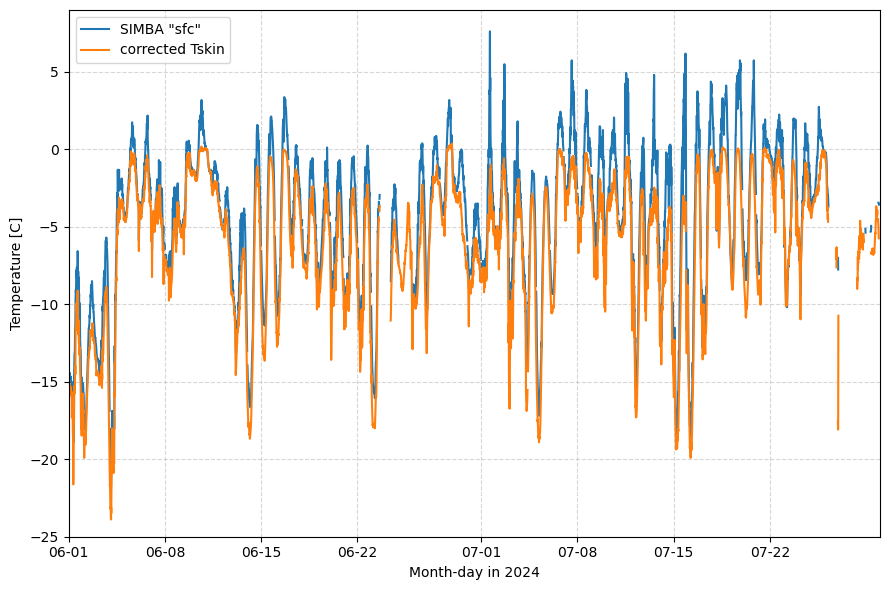

In [18]:
fig, ax = plt.subplots(1, figsize=(9,6))

plt.plot(simba_dates, simba_sfc_temp, label='SIMBA "sfc"')
plt.plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15, label='corrected Tskin') 
plt.ylabel('Temperature [C]')
plt.xlim(dt(2024,6,1), dt(2024,7,30))
plt.ylim(-25,9)
plt.grid(alpha=.5, ls='--')
plt.legend(loc='best')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
plt.tight_layout()
plt.show()

Make a difference plot - need to dig out code for getting same time steps from SIMBA and SLEIGH...


Actual surface is probably above. Change surface detection? or change bias after?

In [19]:
## from Raven_night_k_retrieval.ipynb
## these have different time resolutions??
## interpolate one of them? Probably SEIGH...

sleigh_idx = np.where((asfs_data_lev2['dates']>dt(2024,6,1))&(asfs_data_lev2['dates']<dt(2024,7,21)))[0]
imb_idx = np.where((simba_dates>dt(2024,6,1))&(simba_dates<dt(2024,7,21)))[0]
wind_idx = np.where((asfs_data_lev2['dates']>dt(2024,6,1))&(asfs_data_lev2['dates']<dt(2024,7,21)))[0]
print(len(imb_idx), len(sleigh_idx), len(wind_idx))

4799 7199 7199


In [20]:
print(asfs_data_lev2['dates'][:3])
print()
print(simba_dates[:3])

[datetime.datetime(2024, 5, 20, 0, 0)
 datetime.datetime(2024, 5, 20, 0, 10)
 datetime.datetime(2024, 5, 20, 0, 20)]

[datetime.datetime(2024, 5, 13, 0, 0)
 datetime.datetime(2024, 5, 13, 0, 15)
 datetime.datetime(2024, 5, 13, 0, 30)]


(4799,) 4799
(4799,) 4799
(4799,) 4799
(4799,) 4799
(7199,) 7199


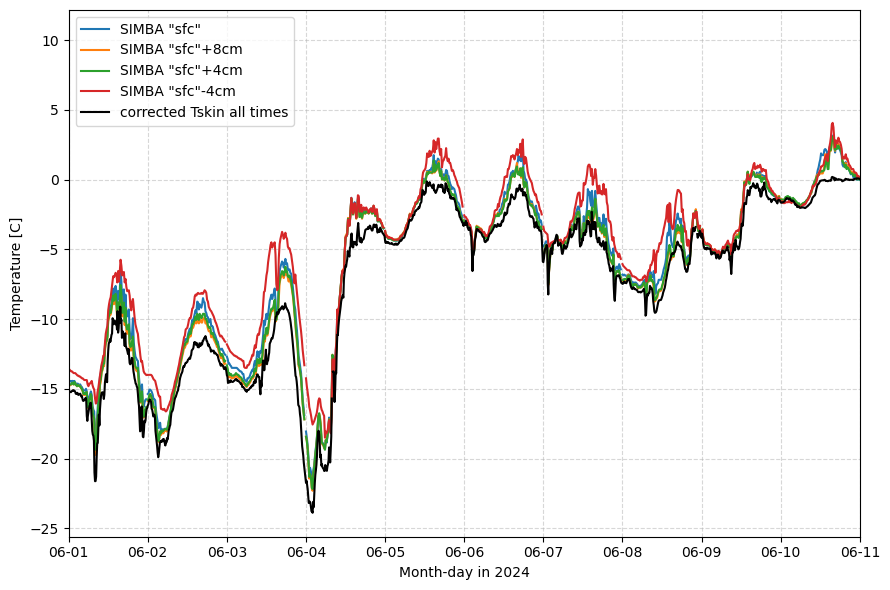

In [21]:
fig, ax = plt.subplots(1, figsize=(9,6))

for offset, lst in zip(['','+8cm','+4cm','-4cm'],[simba_sfc_temp,simba_sfc_10above_temp,simba_sfc_8above_temp,simba_sfc_4below_temp]):
    plt.plot(simba_dates[imb_idx], lst[imb_idx], label='SIMBA "sfc"'+offset)
    print(lst[imb_idx].shape, len(lst[imb_idx]))
    
plt.plot(asfs_data_lev2['dates'][sleigh_idx], sleigh_tskin_all[sleigh_idx]-273.15, label='corrected Tskin all times', c='k') 
# plt.plot(asfs_data_lev2['dates'][sleigh_idx], sleigh_tskin_pos[sleigh_idx]-273.15, label='corrected Tskin positive times',
         # ls='--', c='gray') 
print(sleigh_tskin_all[sleigh_idx].shape, len(sleigh_tskin_all[sleigh_idx]))
plt.ylabel('Temperature [C]')
plt.xlim(dt(2024,6,1), dt(2024,6,11))
# plt.ylim(-25,9)
plt.grid(alpha=.5, ls='--')
plt.legend(loc='best')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
plt.tight_layout()
plt.show()

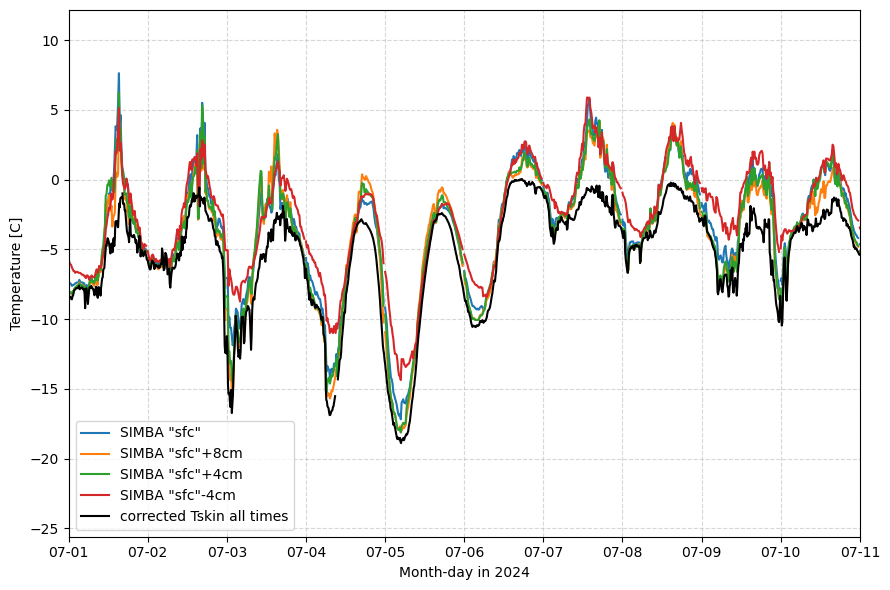

In [22]:
fig, ax = plt.subplots(1, figsize=(9,6))

for offset, lst in zip(['','+8cm','+4cm','-4cm'],[simba_sfc_temp,simba_sfc_10above_temp,simba_sfc_8above_temp,simba_sfc_4below_temp]):
    plt.plot(simba_dates[imb_idx], lst[imb_idx], label='SIMBA "sfc"'+offset)

plt.plot(asfs_data_lev2['dates'][sleigh_idx], sleigh_tskin_all[sleigh_idx]-273.15, label='corrected Tskin all times', c='k') 
# plt.plot(asfs_data_lev2['dates'][sleigh_idx], sleigh_tskin_pos[sleigh_idx]-273.15, label='corrected Tskin positive times', 
         # ls='--', c='gray') 

plt.ylabel('Temperature [C]')
plt.xlim(dt(2024,7,1), dt(2024,7,11))
# plt.ylim(-25,9)
plt.grid(alpha=.5, ls='--')
plt.legend(loc='best')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
plt.tight_layout()
plt.show()

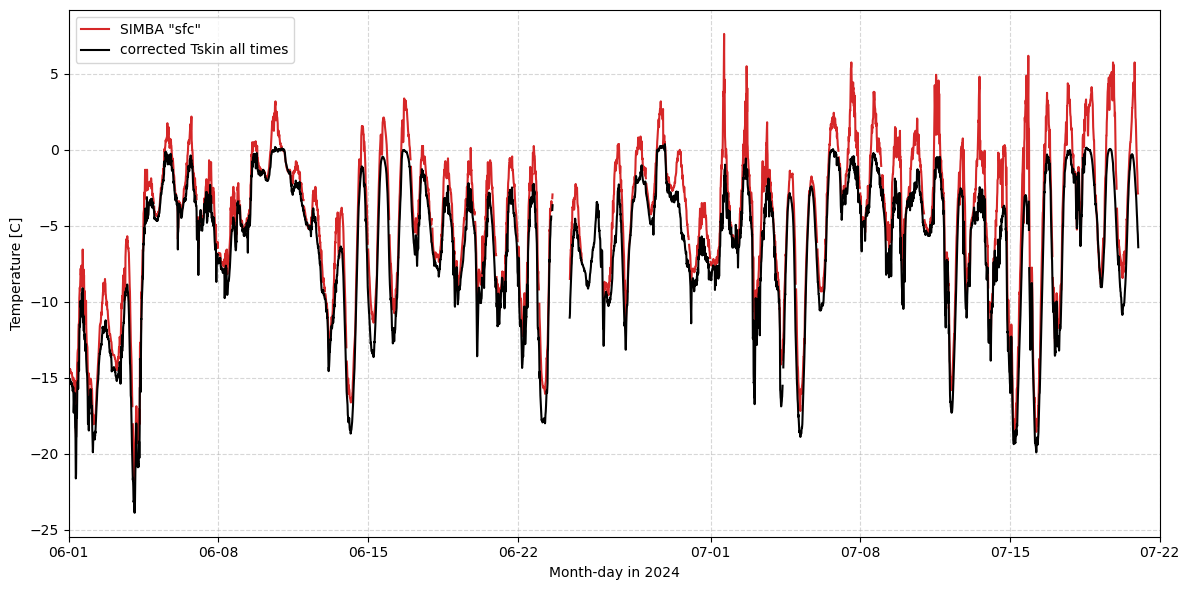

In [23]:
fig, ax = plt.subplots(1, figsize=(12,6))

for offset, lst in zip([''],[simba_sfc_temp,]):
    plt.plot(simba_dates[imb_idx], lst[imb_idx], label='SIMBA "sfc"'+offset, c='tab:red')

plt.plot(asfs_data_lev2['dates'][sleigh_idx], sleigh_tskin_all[sleigh_idx]-273.15, label='corrected Tskin all times', c='k') 
# plt.plot(asfs_data_lev2['dates'][sleigh_idx], sleigh_tskin_pos[sleigh_idx]-273.15, label='corrected Tskin positive times', 
         # ls='--', c='gray') 

plt.ylabel('Temperature [C]')
plt.xlim(dt(2024,6,1), dt(2024,7,22))
# plt.ylim(-25,9)
plt.grid(alpha=.5, ls='--')
plt.legend(loc='best')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
plt.tight_layout()
plt.show()

Interpolate 10 minute sleigh data to 15 minute SIMBA data? or only use overlapping points?

In [31]:
## need to remove masked values for intersection?

In [32]:
## start with overlapping points

same_idx_sleigh = np.intersect1d(asfs_data_lev2['dates'][sleigh_idx], simba_dates[imb_idx], return_indices=True)[1]
same_idx_simba = np.intersect1d(simba_dates[imb_idx], asfs_data_lev2['dates'][sleigh_idx], return_indices=True)[1]


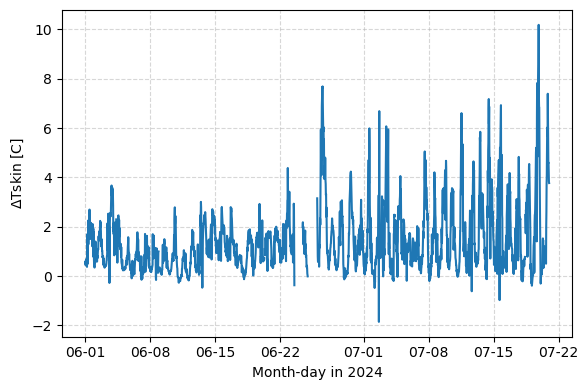

In [33]:
imb_sleigh_dif = simba_sfc_8above_temp[imb_idx][same_idx_simba] - (sleigh_tskin_all[sleigh_idx][same_idx_sleigh]-273.15)
fig, ax = plt.subplots(1, figsize=(6,4))
plt.plot(asfs_data_lev2['dates'][sleigh_idx][same_idx_sleigh], imb_sleigh_dif)
plt.ylabel('$\Delta$Tskin [C]')
plt.grid(alpha=.5, ls='--')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Month-day in 2024')
plt.tight_layout()
plt.show()

In [34]:
asfs_data_lev2['diffuse_frac'] = asfs_data_lev2['down_short_diffuse']/asfs_data_lev2['down_short_direct']


In [35]:
sleigh_deltaT = asfs_data_lev2['temp'][same_idx_sleigh] - (sleigh_tskin_all[sleigh_idx][same_idx_sleigh]-273.15)
simba_deltaT = simba_temperature[:,0][imb_idx][same_idx_simba] - simba_sfc_temp[imb_idx][same_idx_simba]

### Regressions betwen SLEIGH and SIMBA temperatures

-0.2895817637077016


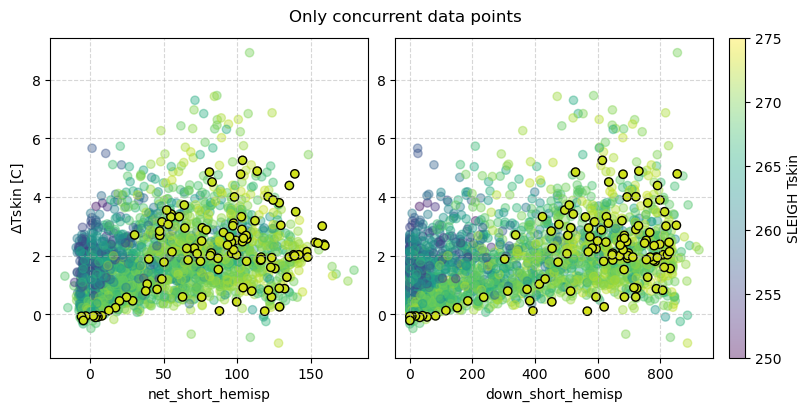

In [36]:
# simba_sfc_10above_temp = 8 cm above ided surface
# simba_sfc_8above_temp = 4 cm above ided surface
# simba_sfc_temp = ided surface

# 'down_short_diffuse','down_short_direct'

imb_sleigh_dif = simba_sfc_temp[imb_idx][same_idx_simba] - (sleigh_tskin_all[sleigh_idx][same_idx_sleigh]-273.15)

melt_idx = np.where(sleigh_tskin_all[sleigh_idx][same_idx_sleigh]>=(273.15-.3))[0]
print(min(sleigh_tskin_all[sleigh_idx][same_idx_sleigh][melt_idx]-273.15))
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

for var, ax in zip(['net_short_hemisp','down_short_hemisp'],axs.ravel()):
    
    cb = ax.scatter(asfs_data_lev2[var][same_idx_sleigh], imb_sleigh_dif, alpha=.4, 
                # c=asfs_data_lev2['up_long_hemisp'][sleigh_idx][same_idx_sleigh])
                    c=sleigh_tskin_all[sleigh_idx][same_idx_sleigh], vmin=250, vmax=275)
    
    ax.scatter(asfs_data_lev2[var][same_idx_sleigh][melt_idx], imb_sleigh_dif[melt_idx], #alpha=.6, 
                    c=sleigh_tskin_all[sleigh_idx][same_idx_sleigh][melt_idx], edgecolors='k', vmin=250, vmax=275)

    ax.set_xlabel(var)
    ax.grid(alpha=.5, ls='--')

plt.colorbar(cb, label='SLEIGH Tskin', ax=axs[1])

axs[0].set_ylabel('$\Delta$Tskin [C]')
fig.suptitle('Only concurrent data points')
# plt.tight_layout()
plt.show()

Same plot with air temperature to check if the relationship is any better (in which case maybe the surface uncertainty is a bigger problem?)

is wind also a factor?

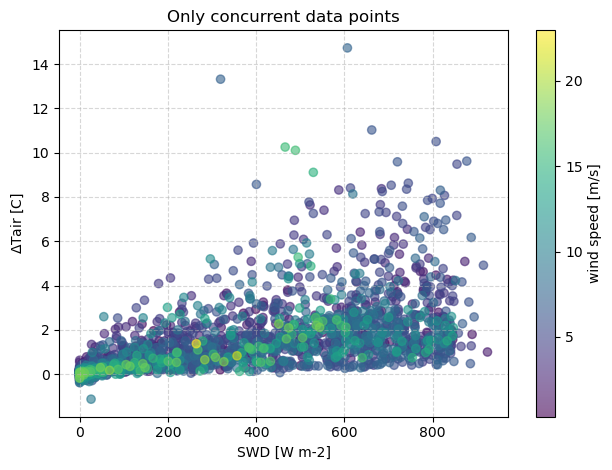

In [37]:
imb_sleigh_dif_air = simba_temperature[:,0][imb_idx][same_idx_simba] - (asfs_data_lev2['temp'][sleigh_idx][same_idx_sleigh])

idx_sort = wind_spd[same_idx_sleigh].argsort()

cb = plt.scatter(asfs_data_lev2['down_short_hemisp'][same_idx_sleigh][idx_sort], imb_sleigh_dif_air[idx_sort], alpha=.6,
               c=wind_spd[same_idx_sleigh][idx_sort])
plt.xlabel('SWD [W m-2]')
plt.ylabel('$\Delta$Tair [C]')
plt.grid(alpha=.5, ls='--')
plt.title('Only concurrent data points')
plt.colorbar(cb, label='wind speed [m/s]')
plt.tight_layout()
plt.show()

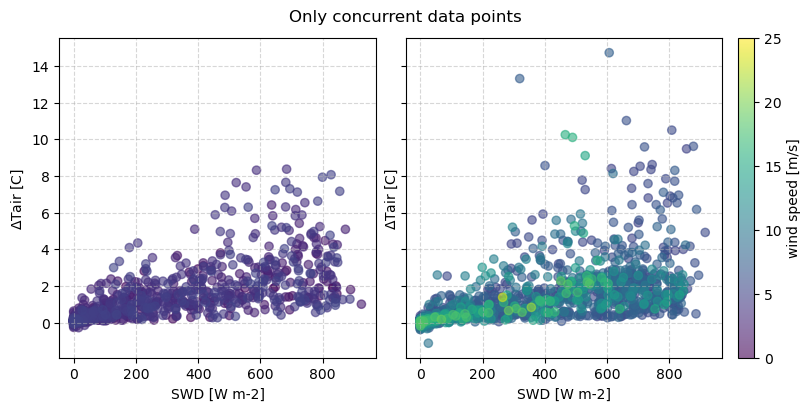

In [38]:
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True, sharex=True, sharey=True)

imb_sleigh_dif_air = simba_temperature[:,0][imb_idx][same_idx_simba] - (asfs_data_lev2['temp'][sleigh_idx][same_idx_sleigh])

idx_sort = wind_spd[same_idx_sleigh].argsort()

mid_pt = 5

cb = axs[0].scatter(asfs_data_lev2['down_short_hemisp'][same_idx_sleigh][idx_sort], 
                    np.ma.masked_where(wind_spd[same_idx_sleigh]>mid_pt, imb_sleigh_dif_air)[idx_sort],
               c=wind_spd[same_idx_sleigh][idx_sort], vmin=0, vmax=25, alpha=.6,)
cb = axs[1].scatter(asfs_data_lev2['down_short_hemisp'][same_idx_sleigh][idx_sort], 
                    np.ma.masked_where(wind_spd[same_idx_sleigh]<=mid_pt, imb_sleigh_dif_air)[idx_sort],
               c=wind_spd[same_idx_sleigh][idx_sort], vmin=0, vmax=25, alpha=.6,)

for ax in axs.ravel():
    ax.set_xlabel('SWD [W m-2]')
    ax.set_ylabel('$\Delta$Tair [C]')
    ax.grid(alpha=.5, ls='--')
fig.suptitle('Only concurrent data points')
plt.colorbar(cb, label='wind speed [m/s]', ax=axs[-1])
# plt.tight_layout()
plt.show()

Maybe accumulated SW over the day will correlate more? As in, the more the sensor is exposed to sunlight the warmer it gets?

In [39]:
sleigh_dates_copy = np.copy(asfs_data_lev2['dates'])
# print(sleigh_dates_copy.shape)
sleigh_dates_copy = sleigh_dates_copy.reshape(6*24, int(sleigh_dates_copy.shape[0]/(6*24)))
# print(sleigh_dates_copy.shape)

sleigh_sw_copy = np.ma.copy(asfs_data_lev2['down_short_hemisp'])
sleigh_sw_copy = sleigh_sw_copy.reshape(6*24, int(sleigh_sw_copy.shape[0]/(6*24)))
daily_sw_accum = np.ma.cumsum(sleigh_sw_copy, axis=0)

daily_sw_accum = daily_sw_accum.reshape(asfs_data_lev2['down_short_hemisp'].shape[0])

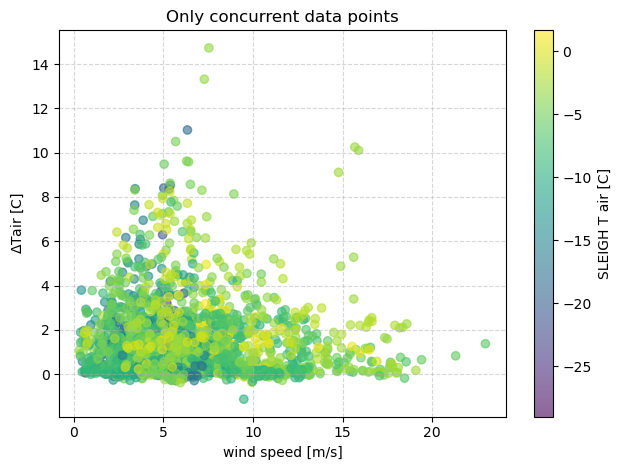

In [40]:
imb_sleigh_dif_air = simba_temperature[:,0][imb_idx][same_idx_simba] - (asfs_data_lev2['temp'][sleigh_idx][same_idx_sleigh])

cb = plt.scatter(wind_spd[same_idx_sleigh], imb_sleigh_dif_air, alpha=.6,
               c=asfs_data_lev2['temp'][same_idx_sleigh]) #asfs_data_lev2[cvar]
plt.xlabel('wind speed [m/s]')
plt.ylabel('$\Delta$Tair [C]')
plt.grid(alpha=.5, ls='--')
plt.title('Only concurrent data points')
plt.colorbar(cb, label='SLEIGH T air [C]')
plt.tight_layout()
plt.show()

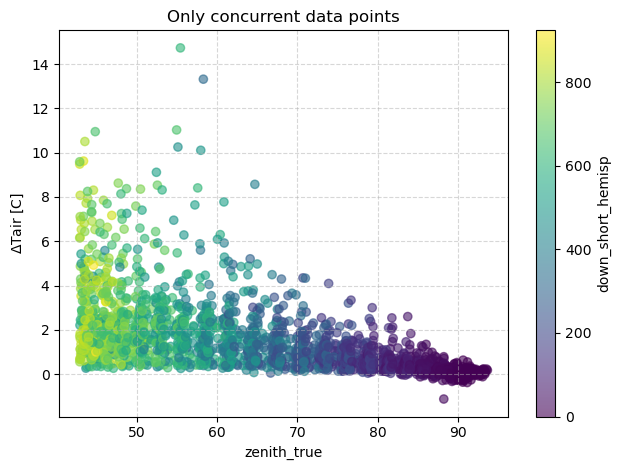

In [41]:
imb_sleigh_dif_air = simba_temperature[:,0][imb_idx][same_idx_simba] - (asfs_data_lev2['temp'][sleigh_idx][same_idx_sleigh])

cvar = 'down_short_hemisp'
xvar = 'zenith_true'
cb = plt.scatter(asfs_data_lev2[xvar][same_idx_sleigh], imb_sleigh_dif_air, alpha=.6,
               c=asfs_data_lev2[cvar][same_idx_sleigh]) #
plt.xlabel(xvar)
plt.ylabel('$\Delta$Tair [C]')
plt.grid(alpha=.5, ls='--')
plt.title('Only concurrent data points')
plt.colorbar(cb, label=cvar)
plt.tight_layout()
plt.show()

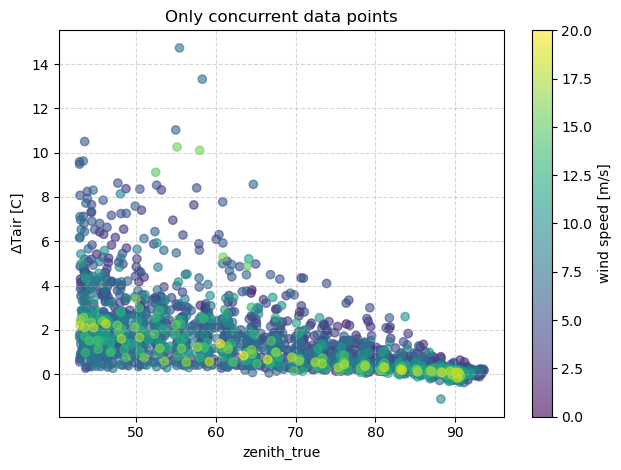

In [42]:
imb_sleigh_dif_air = simba_temperature[:,0][imb_idx][same_idx_simba] - (asfs_data_lev2['temp'][sleigh_idx][same_idx_sleigh])
idx_sort = wind_spd[same_idx_sleigh].argsort()

cvar = 'down_short_hemisp'
xvar = 'zenith_true'
cb = plt.scatter(asfs_data_lev2[xvar][same_idx_sleigh][idx_sort], imb_sleigh_dif_air[idx_sort], alpha=.6,
               c=wind_spd[same_idx_sleigh][idx_sort], vmin=0, vmax=20) #
plt.xlabel(xvar)
plt.ylabel('$\Delta$Tair [C]')
plt.grid(alpha=.5, ls='--')
plt.title('Only concurrent data points')
plt.colorbar(cb, label='wind speed [m/s]')
plt.tight_layout()
plt.show()

What does the near surface temperature gradient look like between SIMBA and SLEIGH?

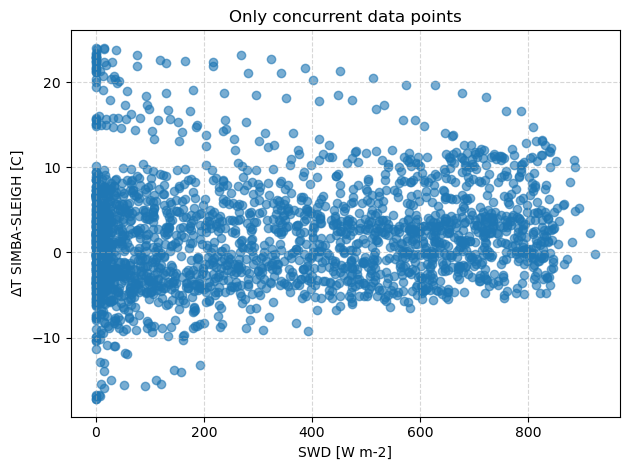

In [43]:
deltaT_dif = simba_deltaT - sleigh_deltaT

plt.scatter(asfs_data_lev2['down_short_hemisp'][same_idx_sleigh], deltaT_dif, alpha=.6)
plt.xlabel('SWD [W m-2]')
plt.ylabel('$\Delta$T SIMBA-SLEIGH [C]')
plt.grid(alpha=.5, ls='--')
plt.title('Only concurrent data points')

plt.tight_layout()
plt.show()

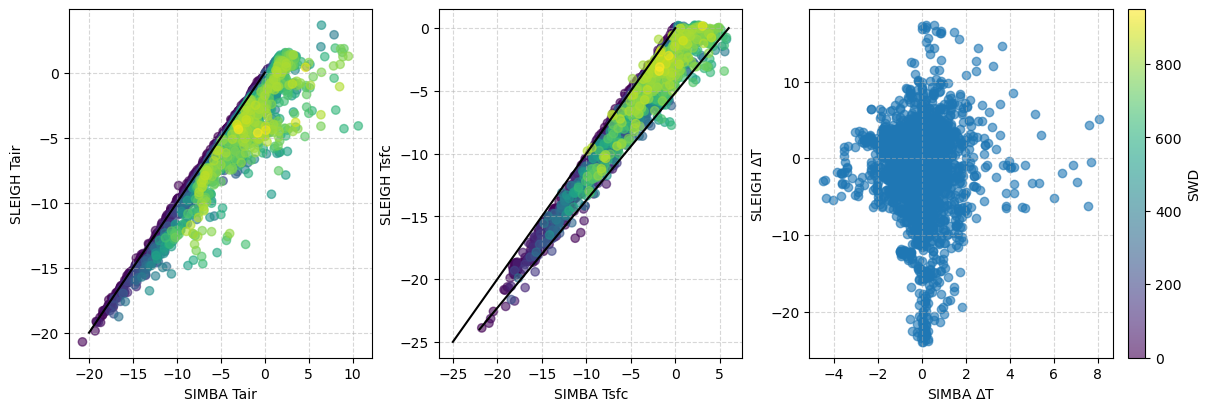

In [44]:
fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)

cvar = asfs_data_lev2['down_short_hemisp'][sleigh_idx][same_idx_sleigh]
# cvar = wind_spd[sleigh_idx][same_idx_sleigh]
idx_sort = cvar.argsort()#[::-1]

axs[0].scatter(simba_temperature[:,0][imb_idx][same_idx_simba][idx_sort], (asfs_data_lev2['temp'][sleigh_idx][same_idx_sleigh])[idx_sort], 
               alpha=.6,
               c=cvar[idx_sort])
              # c=asfs_data_lev2['down_short_hemisp'][sleigh_idx][same_idx_sleigh])

cb = axs[1].scatter(simba_sfc_temp[imb_idx][same_idx_simba][idx_sort], (sleigh_tskin_all[sleigh_idx][same_idx_sleigh]-273.15)[idx_sort],
                    alpha=.6,
                    c=cvar[idx_sort])
              # c=asfs_data_lev2['down_short_hemisp'][sleigh_idx][same_idx_sleigh])
plt.colorbar(cb, label='SWD', ax=axs[-1])
axs[2].scatter(simba_deltaT, sleigh_deltaT, alpha=.6)

for title, ax in zip(['Tair', 'Tsfc', '$\Delta$T'], axs.ravel()):
    ax.grid(alpha=.5, ls='--')
    ax.set_ylabel('SLEIGH '+title)
    ax.set_xlabel('SIMBA '+title)

axs[0].plot([-20,0],[-20,0], c='k')
axs[1].plot([-25,0],[-25,0], c='k')
axs[1].plot([-22,6],[-24,0], c='k')

plt.show()

Apply same method for LW skin correction to SIMBA? ie pick melting days and make bias correction w/ SW?

Or just correct to SLEIGH skin temperature?

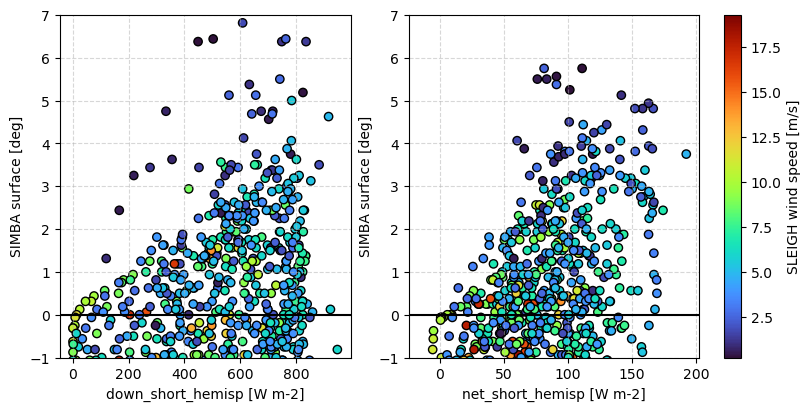

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
# melt_idx = np.where(sleigh_tskin_all[sleigh_idx][same_idx_sleigh]>=(273.15-.3))[0]
wind_spd2 = wind_spd**2
for sw, temp, ax in zip(['down_short_hemisp','net_short_hemisp'],[simba_temperature[:,0],simba_sfc_temp],axs.ravel()):

    cb=ax.scatter(asfs_data_lev2[sw][sleigh_idx][same_idx_sleigh], temp[imb_idx][same_idx_simba], 
               # edgecolor='k', c='tab:orange', label='SLEIGH Tskin~0')#asfs_data_lev2['diffuse_frac'][sleigh_idx][same_idx_sleigh][melt_idx])#c='tab:blue')
               edgecolor='k', c=wind_spd[sleigh_idx][same_idx_sleigh], label='SLEIGH Tskin~0',
              cmap=plt.cm.turbo)#asfs_data_lev2['diffuse_frac'][sleigh_idx][same_idx_sleigh][melt_idx])#c='tab:blue')

    ax.grid(alpha=.5, ls='--')
    ax.set_ylabel('SIMBA surface [deg]')
    ax.set_xlabel(sw + ' [W m-2]')
    ax.set_ylim(-1,7)
    ax.axhline(y=0, c='k')
# axs[1].legend(loc='best')
plt.colorbar(cb, ax=axs[1], label='SLEIGH wind speed [m/s]')
plt.show()

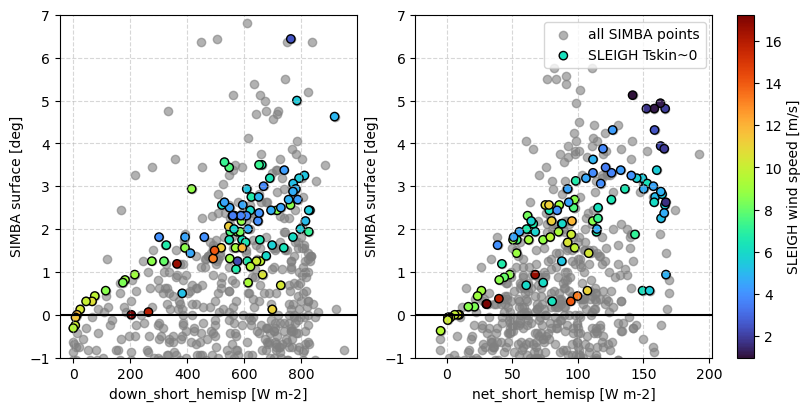

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
# melt_idx = np.where(sleigh_tskin_all[sleigh_idx][same_idx_sleigh]>=(273.15-.3))[0]
wind_spd2 = wind_spd**2
for sw, temp, ax in zip(['down_short_hemisp','net_short_hemisp'],[simba_temperature[:,0],simba_sfc_temp],axs.ravel()):
    ax.scatter(asfs_data_lev2[sw][sleigh_idx][same_idx_sleigh], temp[imb_idx][same_idx_simba], alpha=.6, label='all SIMBA points',
              c='gray')
    cb=ax.scatter(asfs_data_lev2[sw][sleigh_idx][same_idx_sleigh][melt_idx], temp[imb_idx][same_idx_simba][melt_idx], 
               # edgecolor='k', c='tab:orange', label='SLEIGH Tskin~0')#asfs_data_lev2['diffuse_frac'][sleigh_idx][same_idx_sleigh][melt_idx])#c='tab:blue')
               edgecolor='k', c=wind_spd[sleigh_idx][same_idx_sleigh][melt_idx], label='SLEIGH Tskin~0',
              cmap=plt.cm.turbo)#asfs_data_lev2['diffuse_frac'][sleigh_idx][same_idx_sleigh][melt_idx])#c='tab:blue')

    ax.grid(alpha=.5, ls='--')
    ax.set_ylabel('SIMBA surface [deg]')
    ax.set_xlabel(sw + ' [W m-2]')
    ax.set_ylim(-1,7)
    ax.axhline(y=0, c='k')
axs[1].legend(loc='best')
plt.colorbar(cb, ax=axs[1], label='SLEIGH wind speed [m/s]')
plt.show()

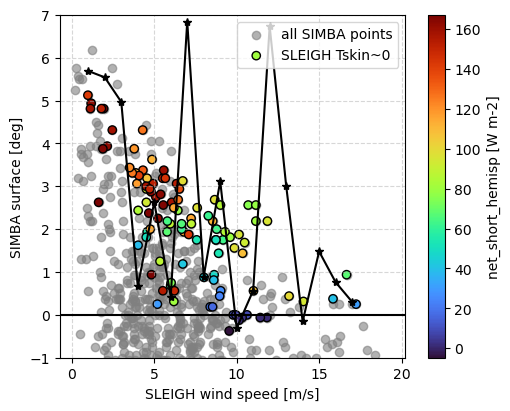

In [47]:
fig, ax = plt.subplots(1,figsize=(5,4), constrained_layout=True)
# melt_idx = np.where(sleigh_tskin_all[sleigh_idx][same_idx_sleigh]>=(273.15-.3))[0]


temp = simba_sfc_temp
sw = 'net_short_hemisp'
ax.scatter(wind_spd[sleigh_idx][same_idx_sleigh], temp[imb_idx][same_idx_simba], 
           alpha=.6, label='all SIMBA points', c='gray')

cb=ax.scatter(wind_spd[sleigh_idx][same_idx_sleigh][melt_idx], temp[imb_idx][same_idx_simba][melt_idx], 
           edgecolor='k', c=asfs_data_lev2[sw][sleigh_idx][same_idx_sleigh][melt_idx], label='SLEIGH Tskin~0',
           cmap=plt.cm.turbo)

example_xs = wind_spd[sleigh_idx][same_idx_sleigh][melt_idx]
example_ys = temp[imb_idx][same_idx_simba][melt_idx]

sort_idx = example_xs.argsort()

## not behaving how I think it should here!!!
t, c, k = interpolate.splrep(example_xs[sort_idx], example_ys[sort_idx], s=20, k=3)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

fake_xs = np.arange(0,20)
plt.plot(fake_xs, spline(fake_xs), c='k', marker='*')


ax.grid(alpha=.5, ls='--')
ax.set_ylabel('SIMBA surface [deg]')
ax.set_xlabel('SLEIGH wind speed [m/s]')
ax.set_ylim(-1,7)
ax.axhline(y=0, c='k')
ax.legend(loc='best')
plt.colorbar(cb, ax=ax, label=sw + ' [W m-2]')
plt.show()

#### Try adjusting surface w/in uncertainty
Was thinking that uncertainty in the surface height could account for some of the scatter in the above SW vs SIMBA temp plots, but adjusting within a couple levels doesn't seem to have a large impact on points with large SW but small bias


In [39]:
lo_bias_idx = np.where((asfs_data_lev2['net_short_hemisp'][sleigh_idx][same_idx_sleigh][melt_idx]>70)&(simba_sfc_temp[imb_idx][same_idx_simba][melt_idx]<1))[0]

In [40]:
print(simba_dates[imb_idx][same_idx_simba][melt_idx][lo_bias_idx])

[datetime.datetime(2024, 6, 5, 12, 30)
 datetime.datetime(2024, 6, 16, 15, 0)
 datetime.datetime(2024, 6, 16, 15, 30)
 datetime.datetime(2024, 6, 28, 12, 30)
 datetime.datetime(2024, 6, 28, 19, 0)
 datetime.datetime(2024, 6, 28, 19, 30)
 datetime.datetime(2024, 7, 6, 14, 0)
 datetime.datetime(2024, 7, 18, 15, 30)]


In [41]:
print(simba_sfc[imb_idx][same_idx_simba][melt_idx][lo_bias_idx])

[-332.0 -328.0 -328.0 -304.0 -302.0 -302.0 -302.0 -302.0]


In [42]:
print(season_data['temperature'].shape)

(9504, 241)


In [43]:
simba_heights_melting = simba_sfc[imb_idx][same_idx_simba][melt_idx]
simba_dates_melting = simba_dates[imb_idx][same_idx_simba][melt_idx]
simba_temps_melting = simba_sfc_temp[imb_idx][same_idx_simba][melt_idx]
simba_temp_profs_melting = season_data['temperature'][imb_idx,:][same_idx_simba,:][melt_idx,:]

In [44]:
print(simba_heights_melting[lo_bias_idx])

[-332.0 -328.0 -328.0 -304.0 -302.0 -302.0 -302.0 -302.0]


In [45]:
simba_heights_melting[lo_bias_idx] -= 2

In [46]:
print(simba_heights_melting[lo_bias_idx])

[-334.0 -330.0 -330.0 -306.0 -304.0 -304.0 -304.0 -304.0]


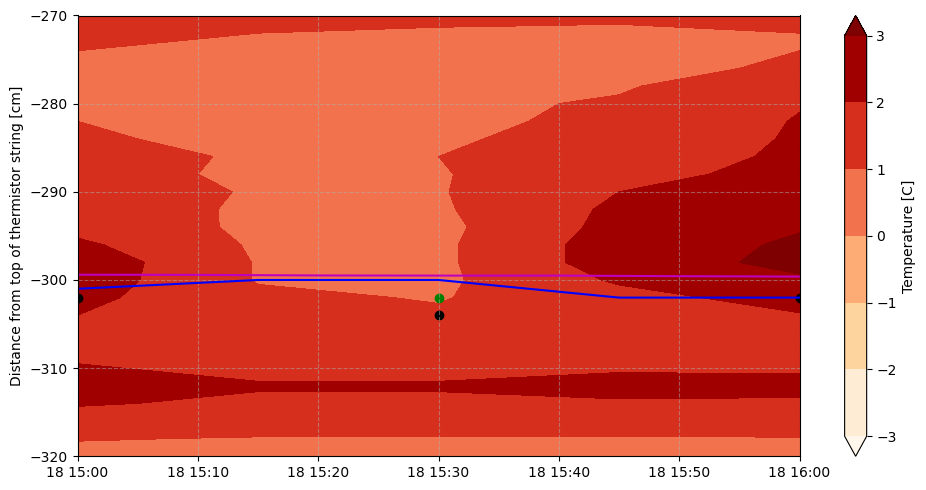

In [47]:
## BETTER COLORMAP!!!

fig, ax = plt.subplots(1, figsize=(10,5))

## figure out pythonic looping later
cb = ax.contourf(simba_dates, season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
plt.colorbar(cb, ax=ax, label='Temperature [C]')
cb = ax.contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                levels=[0], extend='both')

ax.plot(simba_dates, simba_sfc_heights, c='b')
ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth']-350, c='m')

ax.set_ylim(-320, -270)
ax.set_xlim(dt(2024,5,15), dt(2024,7,25))
ax.set_ylabel('Distance from top of thermistor string [cm]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=-209*2, c='k', lw=1) ## top of ice chunk discovered at demob

ax.scatter(simba_dates[imb_idx][same_idx_simba][melt_idx][lo_bias_idx], simba_sfc[imb_idx][same_idx_simba][melt_idx][lo_bias_idx], c='g')
ax.scatter(simba_dates_melting, simba_heights_melting, c='k')

for therm in [190, 200, 215]:
    ax.axhline(y=-therm*2, c='k', lw=1, ls='--')

# ax.set_ylim(-360, -270)
ax.set_xlim(dt(2024,7,18, 15), dt(2024,7,18,16))

plt.tight_layout()
plt.show()

In [48]:
simba_sfc_temp_adjust = []


for t, height in enumerate(simba_heights_melting):
    if np.ma.is_masked(height):
        simba_sfc_temp_adjust.append(-999)
        continue

    idx = np.ma.where(simba_heights==height)[0]
    print(height,idx)
    simba_sfc_temp_adjust.append(np.squeeze(simba_temp_profs_melting[t,idx]))


# simba_sfc_temp = np.asarray(simba_sfc_temp)
simba_sfc_temp_adjust = np.ma.masked_equal(simba_sfc_temp_adjust, -999)


-334.0 [167]
-332.0 [166]
-332.0 [166]
-330.0 [165]
-324.0 [162]
-324.0 [162]
-324.0 [162]
-324.0 [162]
-324.0 [162]
-324.0 [162]
-324.0 [162]
-324.0 [162]
-324.0 [162]
-324.0 [162]
-326.0 [163]
-326.0 [163]
-326.0 [163]
-326.0 [163]
-326.0 [163]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-330.0 [165]
-330.0 [165]
-328.0 [164]
-328.0 [164]
-326.0 [163]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-328.0 [164]
-326.0 [163]
-306.0 [153]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-304.0 [152]
-304.0 [152]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-304.0 [152]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-302.0 [151]
-300.0 [150]

In [49]:
print(simba_dates_melting.shape, simba_heights_melting.shape, simba_sfc_temp_adjust.shape)

(110,) (110,) (110,)


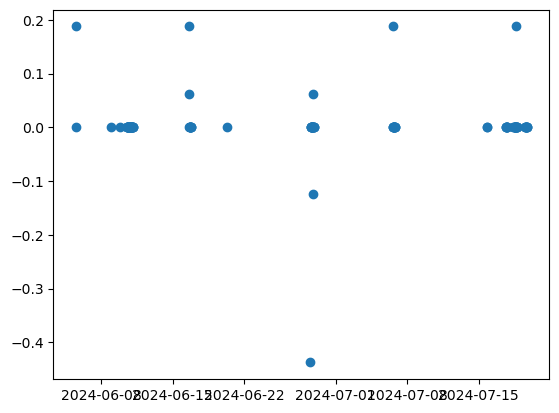

In [50]:
# plt.scatter(simba_dates_melting, simba_temps_melting)
# plt.scatter(simba_dates_melting, simba_sfc_temp_adjust)
plt.scatter(simba_dates_melting, simba_sfc_temp_adjust-simba_temps_melting)
plt.show()

### See if SW extinction coefficients can be tuned for subsurface snow to reduce temperatures to max out at zero

In [48]:
# Interpolate SWN to have same timesteps as SIMBA data

sleigh_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in asfs_data_lev2['dates']])
simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_dates])

swn = asfs_data_lev2['net_short_hemisp']
f_0 = interpolate.interp1d(sleigh_seconds[~swn.mask], swn[~swn.mask], fill_value=-999, bounds_error=False)
simba_swn = f_0(simba_seconds)
simba_swn = np.ma.masked_equal(simba_swn, -999)

f_0 = interpolate.interp1d(sleigh_seconds[~wind_spd.mask], wind_spd[~wind_spd.mask], fill_value=-999, bounds_error=False)
simba_wspd = f_0(simba_seconds)
simba_wspd = np.ma.masked_equal(simba_wspd, -999)


In [49]:
def calc_sw_ext(sw_sfc, kappa, depths_in, f_nir=0.5):
    """ swc_sfc is net SW from the atmosphere (SWD-SWU) 
    kappa is snow extinction coefficient, which is going to be used as a tuning parameter
    f_nir is the fraction of SW that is assumed to be NIR (as opposed to visible)
    depths is assumed to be centimeters below the surface with intervals of 2cm, i.e., 2, 4, 6 etc 
    should depths start at 0 or 2? """

    ## so that absorbed SW, clacluated as the difference between levels, covers the temperature
    depths_in += .01

    ## transmitted SW at each level
    sw_t = f_nir*sw_sfc*np.ma.exp(-kappa*abs(depths_in))

    ## absorbed SW at each level
    # indexing will need to change to use SWN timeseries
    sw_a = sw_t[:,:-1] - sw_t[:,1:]

    sfc_sw_a = sw_sfc[:,0]-sw_t[:,1]

    sw_a = np.concatenate((sfc_sw_a[:, np.newaxis], sw_a), axis=1)
    
    return sw_a, sw_t

In [50]:
def calc_sw_ext_only_expon(sw_sfc, kappa, depths_in, f_nir=0.5):
    """ swc_sfc is net SW from the atmosphere (SWD-SWU) 
    kappa is snow extinction coefficient, which is going to be used as a tuning parameter
    f_nir is the fraction of SW that is assumed to be NIR (as opposed to visible)
    depths is assumed to be centimeters below the surface with intervals of 2cm, i.e., 2, 4, 6 etc 
    should depths start at 0 or 2? """

    ## so that absorbed SW, clacluated as the difference between levels, covers the temperature
    # depths_in += .01

    ## transmitted SW at each level
    sw_t = f_nir*sw_sfc*np.ma.exp(-kappa*abs(depths_in))

    ## absorbed SW at each level
    # indexing will need to change to use SWN timeseries
    sw_a = sw_t[:,:-1] - sw_t[:,1:]

    sfc_sw_a = sw_sfc[:,0]-sw_t[:,1]

    sw_a = np.concatenate((sfc_sw_a[:, np.newaxis], sw_a), axis=1)
    
    return sw_a, sw_t

## test with generic values
dpths = np.arange(0,.40,.02)

sw_abs, sw_trans = calc_sw_ext(100., 16., dpths, f_nir=.5)

plt.plot(sw_abs, -dpths)
plt.ylabel('Distance form surface [cm]')
plt.xlabel('SW absorbed [Wm-2]')
plt.grid(ls='--', alpha=.5)
plt.show()

85.00541910326929


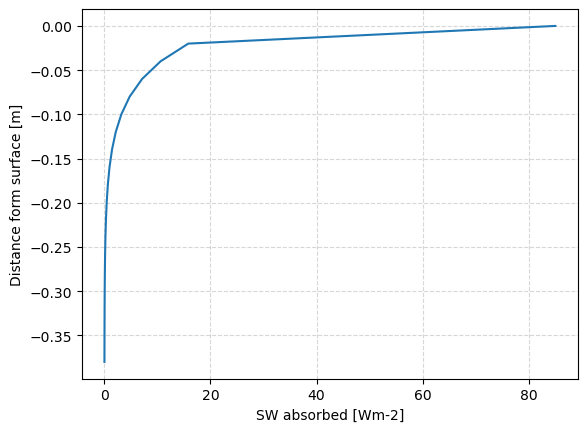

In [217]:
dpths = np.arange(0,.40,.02)
dpths_2d = np.repeat(dpths[np.newaxis,:], simba_swn.shape[0], axis=0)
simba_swn_2d = np.repeat(simba_swn[:,np.newaxis], dpths.shape[0], axis=1)

# ignore negative values for now????
simba_swn_2d = np.ma.masked_less(simba_swn_2d, 0)
ks_vis = 20.
sw_abs, sw_trans = calc_sw_ext(simba_swn_2d, ks_vis, dpths, f_nir=.5)
sw_abs = np.ma.masked_array(sw_abs, mask=simba_swn_2d.mask)

print(sw_abs[1020,0])
plt.plot(sw_abs[1020,:], -dpths_2d[0,:])
plt.ylabel('Distance form surface [m]')
plt.xlabel('SW absorbed [Wm-2]')
plt.grid(ls='--', alpha=.5)
plt.show()


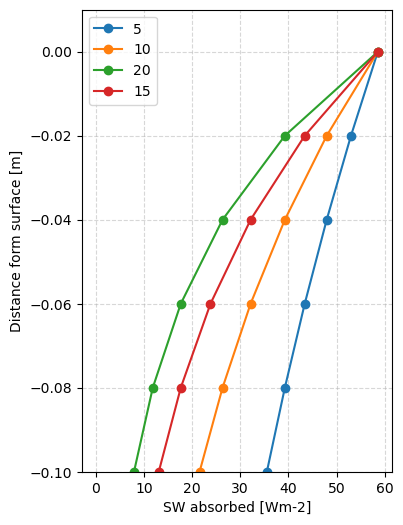

In [52]:
dpths = np.arange(0,.40,.02)
dpths_2d = np.repeat(dpths[np.newaxis,:], simba_swn.shape[0], axis=0)
simba_swn_2d = np.repeat(simba_swn[:,np.newaxis], dpths.shape[0], axis=1)

    # ignore negative values for now????

fig, ax = plt.subplots(1, figsize=(4,6))
for ks_vis in [5,10,20,15]:
    simba_swn_2d = np.ma.masked_less(simba_swn_2d, 0)
    # ks_vis = 15.
    sw_abs, sw_trans = calc_sw_ext_only_expon(simba_swn_2d, ks_vis, dpths, f_nir=.5)
    # sw_abs, sw_trans = calc_sw_ext(simba_swn_2d, ks_vis, dpths, f_nir=1.)
    sw_abs = np.ma.masked_array(sw_abs, mask=simba_swn_2d.mask)

    plt.plot(sw_trans[1020,:], -dpths_2d[0,:], label=ks_vis, marker='o')

    # plt.plot(sw_trans[1020,:-1]-sw_trans[1020,1:], -dpths_2d[0,:-1], label=ks_vis)
plt.ylabel('Distance form surface [m]')
plt.xlabel('SW absorbed [Wm-2]')
plt.grid(ls='--', alpha=.5)
plt.legend(loc='best')

plt.ylim(-.1,.01)
# plt.xlim(0,20)
plt.show()


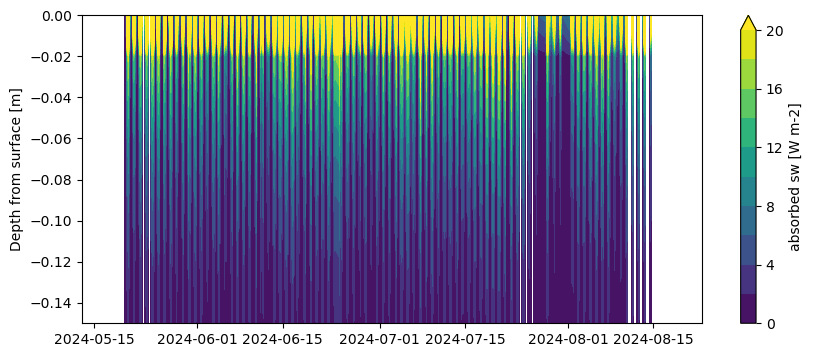

In [53]:
fig, ax = plt.subplots(1, figsize=(10,4))
cb = plt.contourf(simba_dates, -dpths_2d[0,:], np.swapaxes(sw_abs,0,1), levels=np.linspace(0,20,11), extend='max')
plt.colorbar(cb, label='absorbed sw [W m-2]')
plt.ylabel('Depth from surface [m]')
plt.ylim(-.15,0)
plt.show()

### Try to relate temperature bias and SW absorption

Next steps: combining extinction profiles with temperatures above 0

Need to get temperatures below surface instead of along SIMBA

Possible to take into account conduction of string?


### Start with one time step: SW profile and temperatures


In [218]:
day_idx = np.where((simba_dates>dt(2024,6,15))&(simba_dates<dt(2024,6,16)))[0]

day_peak_idx = np.where(nearest(simba_dates, dt(2024,6,15,18))==simba_dates)[0]
print(day_peak_idx)

[3240]


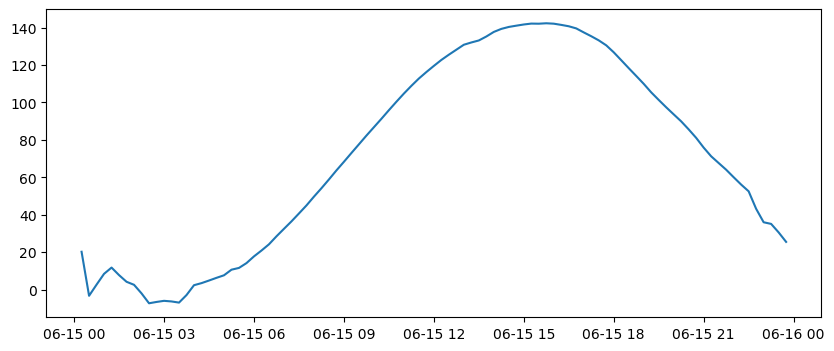

In [219]:
fig, ax = plt.subplots(1, figsize=(10,4))

plt.plot(simba_dates[day_idx], simba_swn[day_idx])
plt.show()

In [220]:
print(season_data['temperature'].shape)
print(simba_sfc_heights[day_peak_idx])
print(simba_swn[day_peak_idx])

(9504, 241)
[-328.0]
[126.78446999999994]


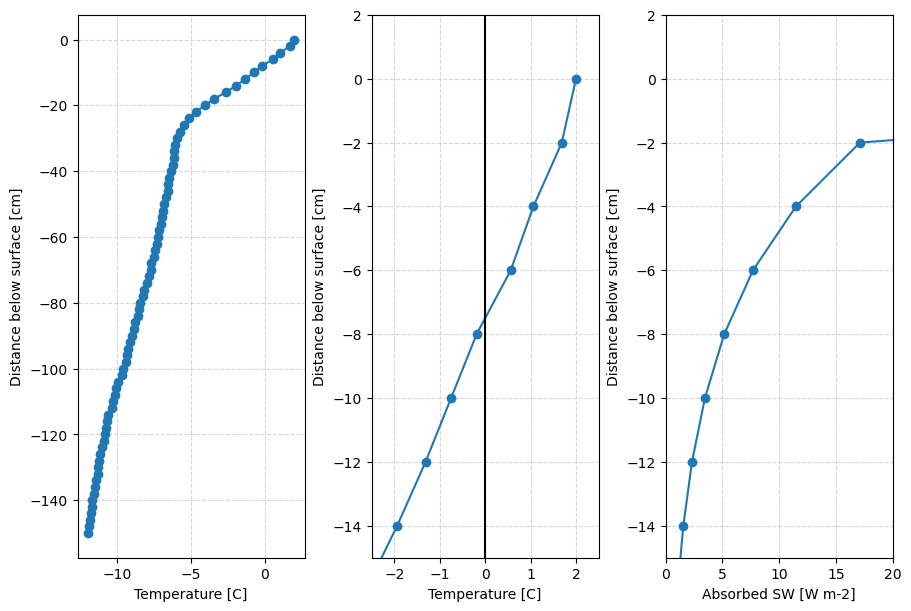

In [221]:
fig, axs = plt.subplots(1, 3, figsize=(9,6), constrained_layout=True)

example_profile = np.squeeze(season_data['temperature'][day_peak_idx,:-1]) # last value is "air temperature" from instrument

## limit to subsurface
subsfc_idx = np.where(simba_depths[:-1]<=simba_sfc_heights[day_peak_idx])[0]

subsfc_depths = simba_depths[subsfc_idx] + abs(simba_sfc_heights[day_peak_idx])

for ax in axs.ravel()[:-1]:
    ax.plot(example_profile[subsfc_idx], subsfc_depths, marker='o')
    ax.grid(alpha=.5, ls='--')
    ax.set_xlabel('Temperature [C]')
    ax.set_ylabel('Distance below surface [cm]')

axs[-1].plot(np.squeeze(sw_abs[day_peak_idx]), -dpths_2d[0,:]*100., marker='o')

for ax in axs.ravel()[1:]:
    ax.set_ylim(-15,2)
    ax.grid(alpha=.5, ls='--')
    ax.set_ylabel('Distance below surface [cm]')
axs[-1].set_xlabel('Absorbed SW [W m-2]')

axs[1].axvline(x=0, c='k')
axs[1].set_xlim(-2.5,2.5)
axs[-1].set_xlim(0,20)

plt.show()

In [222]:
print(sw_abs[day_peak_idx])

[[91.99407379399295 17.11077609483938 11.469696219598255
  7.688367297935901 5.153666721091296 3.454606113734264
  2.3156917291933485 1.5522545865172366 1.0405073658932644
  0.6974729454059945 0.4675300968731603 0.31339479605906373
  0.21007481412164086 0.14081735907294696 0.09439269861639496
  0.06327331808196993 0.04241337348953385 0.028430534470031077
  0.01905755717476902 0.012774662602718027]]


In [223]:
## do this correction only for levels where you suspect melt?

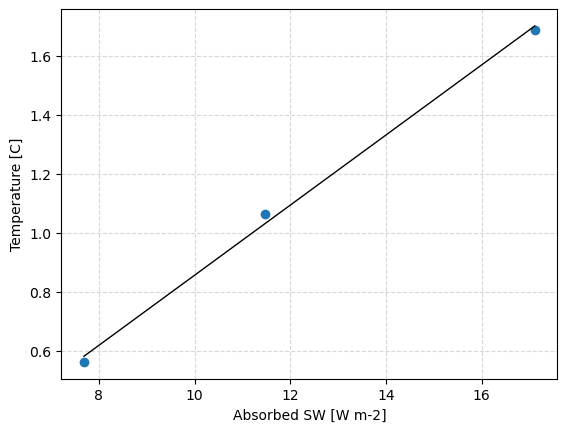

In [224]:
above_zero = np.where(np.squeeze(example_profile[subsfc_idx])>0)[0]

# ignoring surface point because it has different balance and also way more absorbed SW...
xs_sw = np.squeeze(sw_abs[day_peak_idx])[above_zero][1:]
ys_temp = np.squeeze(example_profile[subsfc_idx])[above_zero][1:]

plt.scatter(xs_sw, ys_temp)

plt.plot(np.ma.unique(xs_sw), np.poly1d(np.ma.polyfit(xs_sw, ys_temp, 1))(np.ma.unique(xs_sw)), c='k', lw=1)

plt.grid(alpha=.5, ls='--')
plt.xlabel('Absorbed SW [W m-2]')
plt.ylabel('Temperature [C]')
plt.show()

In [225]:
# subsfc_wind_speeds
## need to create wind speeds that are same shape as simba (repeat along new depth axis)
## then follow what sw_trans is being done in for loop?
simba_wspd_2d = np.repeat(simba_wspd[:,np.newaxis], dpths.shape[0], axis=1)


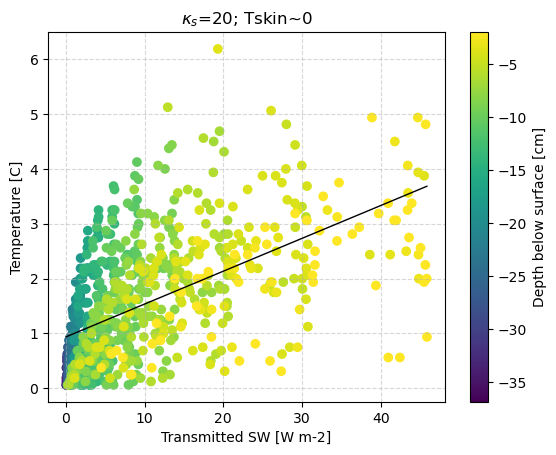

In [226]:
## melt_idx was defined several cells above when comparing surface/skin temperature from SIMBA and SLEIGH



for idx in melt_idx[:]:
    example_profile = season_data['temperature'][imb_idx,:][same_idx_simba,:][idx,:]

    idx_sfc = simba_sfc_heights[imb_idx][same_idx_simba][idx]
    subsfc_idx = np.where(simba_depths[:-1]<=idx_sfc)[0] ## HERE changed [:-1] to [1:]
    example_profile = np.squeeze(example_profile[subsfc_idx])
    too_warm_idx = np.where(example_profile>0)[0]

    sw_abs_warm = sw_trans[imb_idx,:][same_idx_simba,:][idx,:][too_warm_idx]

    wspd_warm = simba_wspd_2d[imb_idx,:][same_idx_simba,:][idx,:][too_warm_idx]
    
    # sw_abs_warm = sw_abs[imb_idx,:][same_idx_simba,:][idx,:][too_warm_idx]
    temp_warm = example_profile[too_warm_idx]

    ## still removing surface value
    if idx==melt_idx[0]:
        all_subsfc_temps_above = temp_warm[1:]
        all_subsfc_swabs_above = sw_abs_warm[1:]
        all_subsfc_depths = simba_depths[:-1][subsfc_idx][too_warm_idx][1:]+abs(idx_sfc)
        all_subsfc_wspd = wspd_warm[1:]
    else:
        all_subsfc_temps_above = np.ma.concatenate((all_subsfc_temps_above, temp_warm[1:]))
        all_subsfc_swabs_above = np.ma.concatenate((all_subsfc_swabs_above, sw_abs_warm[1:]))
        all_subsfc_depths = np.ma.concatenate((all_subsfc_depths, simba_depths[:-1][subsfc_idx][too_warm_idx][1:]+abs(idx_sfc)))
        all_subsfc_wspd = np.ma.concatenate((all_subsfc_wspd, wspd_warm[:-1]))

## need to determine what levels are actually melting??
idx_sort = all_subsfc_depths.argsort()

cb = plt.scatter(all_subsfc_swabs_above[idx_sort], all_subsfc_temps_above[idx_sort], c=all_subsfc_depths[idx_sort])
plt.colorbar(cb, label='Depth below surface [cm]')
plt.plot(np.ma.unique(all_subsfc_swabs_above), np.poly1d(np.ma.polyfit(all_subsfc_swabs_above, all_subsfc_temps_above, 1))(np.ma.unique(all_subsfc_swabs_above)), c='k', lw=1)

plt.grid(alpha=.5, ls='--')
# plt.xlim(-1,20)
# plt.xlabel('Absorbed SW [W m-2]')
plt.xlabel('Transmitted SW [W m-2]')

plt.ylabel('Temperature [C]')
plt.title('$\kappa_s$={:.0f}; Tskin~0'.format(ks_vis))
plt.show()

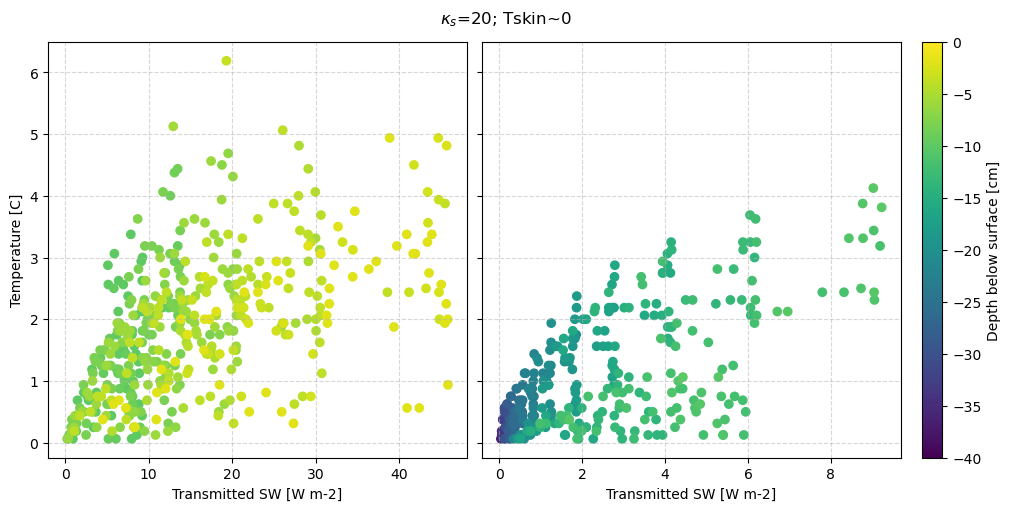

In [227]:
## melt_idx was defined several cells above when comparing surface/skin temperature from SIMBA and SLEIGH


## need to determine what levels are actually melting??
idx_sort = all_subsfc_depths.argsort()

fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True, sharey=True)

cb = axs[0].scatter(all_subsfc_swabs_above[idx_sort], np.ma.masked_where(all_subsfc_depths<-10, all_subsfc_temps_above)[idx_sort], 
                                                                         c=all_subsfc_depths[idx_sort], vmin=-40, vmax=0)
cb = axs[1].scatter(all_subsfc_swabs_above[idx_sort], np.ma.masked_where(all_subsfc_depths>=-10, all_subsfc_temps_above)[idx_sort], 
                                                                         c=all_subsfc_depths[idx_sort], vmin=-40, vmax=0)
plt.colorbar(cb, label='Depth below surface [cm]')
# plt.plot(np.ma.unique(all_subsfc_swabs_above), np.poly1d(np.ma.polyfit(all_subsfc_swabs_above, all_subsfc_temps_above, 1))(np.ma.unique(all_subsfc_swabs_above)), c='k', lw=1)

for ax in axs.ravel():
    ax.grid(alpha=.5, ls='--')
    # plt.xlim(-1,20)
    # plt.xlabel('Absorbed SW [W m-2]')
    ax.set_xlabel('Transmitted SW [W m-2]')

axs[0].set_ylabel('Temperature [C]')
fig.suptitle('$\kappa_s$={:.0f}; Tskin~0'.format(ks_vis))
plt.show()

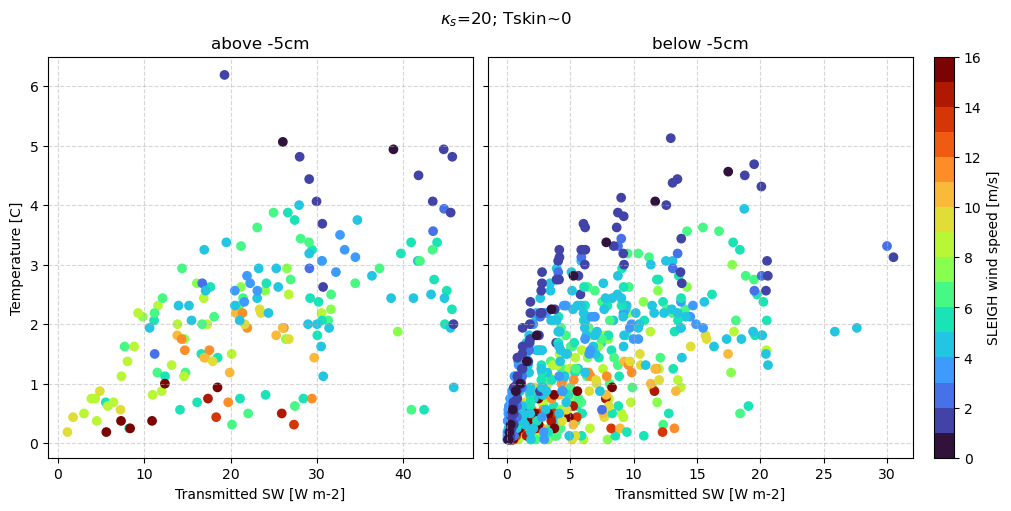

In [228]:
## melt_idx was defined several cells above when comparing surface/skin temperature from SIMBA and SLEIGH


## need to determine what levels are actually melting??

# want discretized colorbar
cmap = plt.cm.turbo
bounds = np.linspace(0, 16, 17)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True, sharey=True)

cb = axs[0].scatter(all_subsfc_swabs_above, np.ma.masked_where(all_subsfc_depths<-5, all_subsfc_temps_above), 
                                                                         c=all_subsfc_wspd, norm=norm, cmap=cmap)
cb = axs[1].scatter(all_subsfc_swabs_above, np.ma.masked_where(all_subsfc_depths>=-5, all_subsfc_temps_above), 
                                                                         c=all_subsfc_wspd, norm=norm, cmap=cmap)
plt.colorbar(cb, label='SLEIGH wind speed [m/s]')
# plt.plot(np.ma.unique(all_subsfc_swabs_above), np.poly1d(np.ma.polyfit(all_subsfc_swabs_above, all_subsfc_temps_above, 1))(np.ma.unique(all_subsfc_swabs_above)), c='k', lw=1)

for ax, title in zip(axs.ravel(),['above -5cm', 'below -5cm']):
    ax.grid(alpha=.5, ls='--')
    # plt.xlim(-1,20)
    # plt.xlabel('Absorbed SW [W m-2]')
    ax.set_xlabel('Transmitted SW [W m-2]')
    ax.set_title(title)

axs[0].set_ylabel('Temperature [C]')
fig.suptitle('$\kappa_s$={:.0f}; Tskin~0'.format(ks_vis))
plt.show()

NOTES: Changing fraction of NIR vs VIS energy in SWN imapcts scale of xaxis but not distribution in x-y space! Changing extinctino coefficient changes behavior aorund (0,0). Notably, and extinction coefficient of 10 m-1 no longer has an intercept of (0,0) whereas as a coefficient of 15 m-1 does.

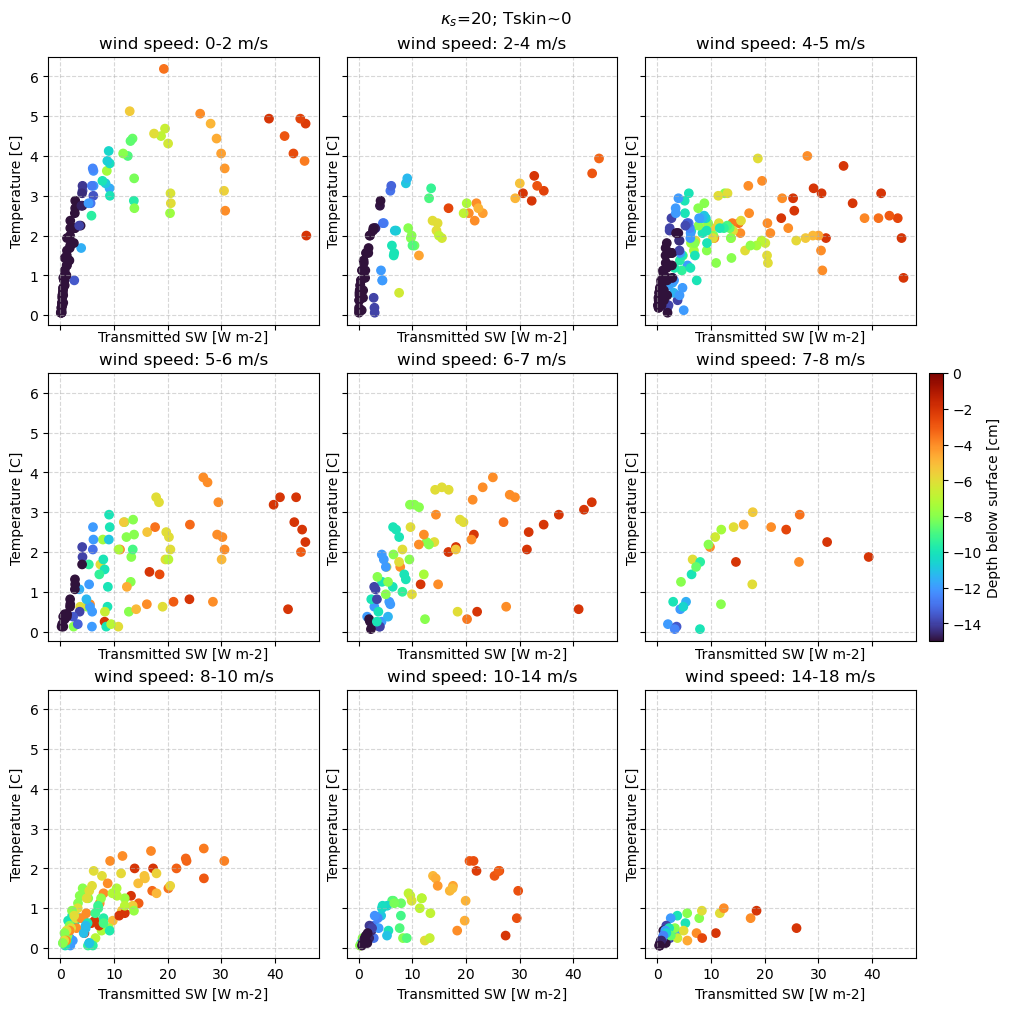

In [229]:
## melt_idx was defined several cells above when comparing surface/skin temperature from SIMBA and SLEIGH


## need to determine what levels are actually melting??

# want discretized colorbar
cmap = plt.cm.turbo

fig, axs = plt.subplots(3,3, figsize=(10,10), constrained_layout=True, sharey=True, sharex=True)

# wind_ranges = np.linspace(0,18,7)
wind_ranges = [0,2,4,5,6,7,8,10,14,18]

for w_lo, w_hi, ax in zip(wind_ranges[:-1],wind_ranges[1:], axs.ravel()):
    
    w_idx = np.where((all_subsfc_wspd>=w_lo)&(all_subsfc_wspd<w_hi))
    cb = ax.scatter(all_subsfc_swabs_above[w_idx], all_subsfc_temps_above[w_idx], 
                    c=all_subsfc_depths[w_idx], vmin=-15, vmax=0, cmap=cmap)
    ax.set_title('wind speed: {:.0f}-{:.0f} m/s'.format(w_lo, w_hi))

    ax.grid(alpha=.5, ls='--')
    ax.set_xlabel('Transmitted SW [W m-2]')
    ax.set_ylabel('Temperature [C]')

plt.colorbar(cb, label='Depth below surface [cm]', ax=axs[1][2])
fig.suptitle('$\kappa_s$={:.0f}; Tskin~0'.format(ks_vis))
plt.show()

In [88]:
def get_max_bin_vals(x_in, y_in, bins_in):
    bins_xs = []
    bins_ys = []
    
    # for b0, b1 in zip(percentiles[:-1], percentiles[1:]):
    for b0, b1 in zip(bins_in[:-1], bins_in[1:]):
        bin_idx = np.where((x_in>=b0)&(x_in<b1))[0]
        # bin_xs.append( np.ma.median(all_subsfc_swabs_above[bin_idx]) )
        bins_xs.append( np.mean([b0,b1]) )
        if len(bin_idx)<1:
            bins_ys.append(np.nan)
        else:
            bin_max = y_in[bin_idx].max()
            bins_ys.append(bin_max)
    
    bins_xs = np.ma.masked_invalid(bins_xs)
    bins_ys = np.ma.masked_invalid(bins_ys)
    
    return bins_xs, bins_ys

In [250]:
def get_percentile_bin_vals(x_in, y_in, bins_in):
    bins_xs = []
    bins_ys = []
    
    for b0, b1 in zip(bins_in[:-1], bins_in[1:]):
        bin_idx = np.where((x_in>=b0)&(x_in<b1))[0]
        # get median of upper quartile (check impact of that choice)

        y_in_bin = y_in[bin_idx]
        
        bins_xs.append( np.mean([b0,b1]) )
        
        if y_in_bin.shape[0]<1:
            bins_ys.append(np.nan)
            # print(x_in_bin.shape)
            continue
            
        bin_upper_quart_val = np.percentile(y_in_bin[~y_in_bin.mask], 50)
        bin_upper_quart_idx = np.ma.where(y_in_bin>=bin_upper_quart_val)
        
        # bin_xs.append( np.ma.median(all_subsfc_swabs_above[bin_idx]) )
        # bins_xs.append( np.mean([b0,b1]) )
        # print(x_in_bin.shape)
        bin_med = np.ma.median(y_in_bin[bin_upper_quart_idx])
        bins_ys.append(bin_med)
    
    bins_xs = np.ma.masked_invalid(bins_xs)
    bins_ys = np.ma.masked_invalid(bins_ys)
    
    return bins_xs, bins_ys

In [251]:
# color_list = ['r','orange','gold','limegreen','teal','mediumblue','mediumorchid','darkmagenta','maroon','grey','k']
color_list = ['r','gold','mediumorchid']

BINS are sensitive to extinction coefficient!

In [252]:
sw_bin_params = {'width0':{15:1, 20:2}, 'width1':{15:10, 20:10}, 'midpt':{15:15, 20:15}}

/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


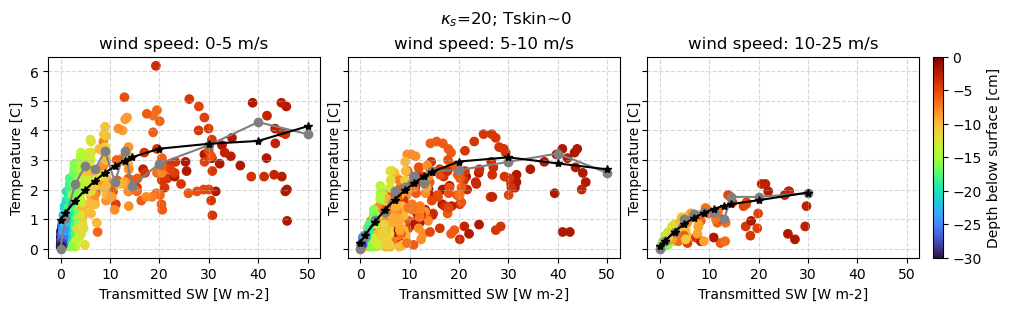

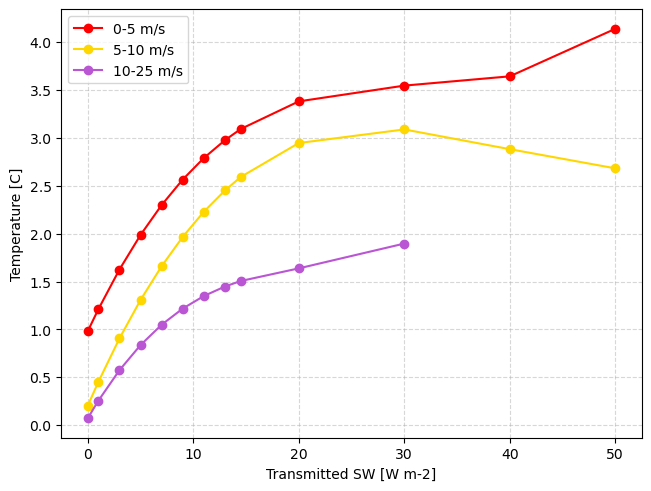

In [253]:
## melt_idx was defined several cells above when comparing surface/skin temperature from SIMBA and SLEIGH


## need to determine what levels are actually melting??

## use same bins for all wind speeds?
# bin_width0 = 1
# bin_width1 = 10
# midpt = 15

# bins = np.ma.concatenate( (np.arange(0, midpt+.01, bin_width0), np.arange(midpt, 70.01, bin_width1)) ) # bins for absorbed SW at depth

bins = np.ma.concatenate( (np.arange(0, sw_bin_params['midpt'][ks_vis]+.01, sw_bin_params['width0'][ks_vis]), 
                           np.arange(sw_bin_params['midpt'][ks_vis], 70.01, sw_bin_params['width1'][ks_vis])) ) # bins for absorbed SW at depth

# want discretized colorbar
cmap = plt.cm.turbo

fig, axs = plt.subplots(1,3, figsize=(10,3), constrained_layout=True, sharey=True, sharex=True)

fig2, ax2 = plt.subplots(1, constrained_layout=True)

# wind_ranges = np.linspace(0,18,7)
# wind_ranges = [0,2,4,5,6,7,8,10,14,18]
# wind_ranges = np.arange(0,10)
wind_ranges = [0,5,10,25]


## save splines for future use as corrections - better way to save?
wind_based_corrections = {}

for i,(w_lo, w_hi, ax) in enumerate(zip(wind_ranges[:-1],wind_ranges[1:], axs.ravel())):

    w_idx = np.where((all_subsfc_wspd>=w_lo)&(all_subsfc_wspd<w_hi))
    sw_wind = all_subsfc_swabs_above[w_idx]
    temp_wind = all_subsfc_temps_above[w_idx]
    
    cb = ax.scatter(sw_wind, temp_wind, 
                    c=all_subsfc_depths[w_idx], vmin=-30, vmax=0, cmap=cmap)

    ## try adding curve using splines
    # bin_xs, bin_ys = get_max_bin_vals(sw_wind, temp_wind, bins)
    bin_xs, bin_ys = get_percentile_bin_vals(sw_wind, temp_wind, bins)

    ## force (0,0) point
    bin_xs = np.ma.concatenate( ([0],bin_xs) )
    bin_ys = np.ma.concatenate( ([0],bin_ys) )

    ax.plot(bin_xs, bin_ys, c='gray', marker='o')

    t, c, k = interpolate.splrep(bin_xs[~bin_ys.mask], bin_ys[~bin_ys.mask], s=5, k=3)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    # wind_based_corrections[w_hi] = spline
    wind_based_corrections[w_hi] = (t, c, k)
    
    ax.plot(bin_xs, spline(bin_xs), c='k', marker='*')

    ax2.plot(bin_xs, spline(bin_xs), marker='o', label='{:.0f}-{:.0f} m/s'.format(w_lo, w_hi), c=color_list[i])

    ax.set_title('wind speed: {:.0f}-{:.0f} m/s'.format(w_lo, w_hi))
    ax.grid(alpha=.5, ls='--')
    ax.set_xlabel('Transmitted SW [W m-2]')
    ax.set_ylabel('Temperature [C]')

plt.colorbar(cb, label='Depth below surface [cm]', ax=axs[2])
fig.suptitle('$\kappa_s$={:.0f}; Tskin~0'.format(ks_vis))


ax2.grid(alpha=.5, ls='--')
ax2.set_xlabel('Transmitted SW [W m-2]')
ax2.set_ylabel('Temperature [C]')
ax2.legend(loc='best')#, bbox_to_anchor=(1.,.6))
plt.show()

## Current plan of attack: do spline fit for bins of wind speed?

Also wonder if its possible to optimize bias correction (extinction cofficient) and surface identification....ask Michael?

#### Old questions and future directions:
How much does extinction coefficient need to vary to reduce the scatter? What is a reasonable range?

Is some of the scatter due to wind pumping?

What impact does uncertainty in surface height have?

In [94]:
### get correction along the maximum values

In [99]:
from scipy.optimize import curve_fit

# def func(x, a, b, c):
#     return a * np.log(b * x) + c
def func(x, a, b):
    return a * np.log(b * x)

760
[ 0.25  0.25  0.25  0.25 57.5  57.5  57.5  57.5 ] [0.25917281 7.44634873 4.51348849 4.3967767  0.         0.
 0.         0.        ] 3


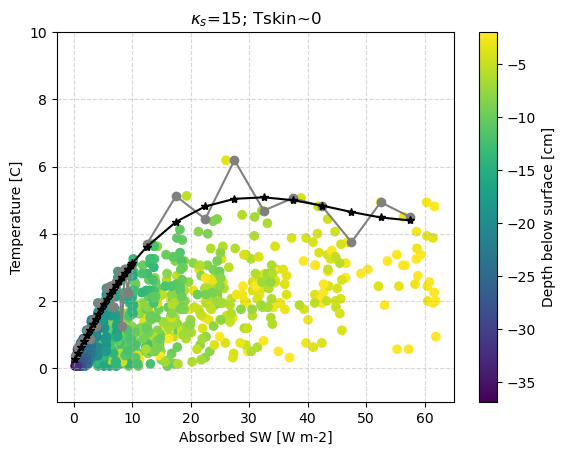

In [100]:
bin_width0 = .5
bin_width1 = 5
midpt = 10

bins = np.ma.concatenate( (np.arange(0, midpt+.01, bin_width0), np.arange(midpt, 60.01, bin_width1)) ) # bins for absorbed SW at depth

# bin_width = 5.
# bins = np.arange(0, 100., bin_width) # bins for absorbed SW at depth
# percentiles = np.percentile(all_subsfc_swabs_above[~all_subsfc_swabs_above.mask], bins)

# bin_xs = bins[1:]-bin_width/2.
# bin_xs = []
# bin_ys = []

# # for b0, b1 in zip(percentiles[:-1], percentiles[1:]):
# for b0, b1 in zip(bins[:-1], bins[1:]):
#     bin_idx = np.where((all_subsfc_swabs_above>=b0)&(all_subsfc_swabs_above<b1))[0]
#     # bin_xs.append( np.ma.median(all_subsfc_swabs_above[bin_idx]) )
#     bin_xs.append( np.mean([b0,b1]) )
#     if len(bin_idx)<1:
#         bin_ys.append(np.nan)
#     else:
#         bin_max = all_subsfc_temps_above[bin_idx].max()
#         bin_ys.append(bin_max)

# bin_xs = np.ma.masked_invalid(bin_xs)
# bin_ys = np.ma.masked_invalid(bin_ys)

bin_xs, bin_ys = get_max_bin_vals(all_subsfc_swabs_above, all_subsfc_temps_above, bins)


cb = plt.scatter(all_subsfc_swabs_above, all_subsfc_temps_above, c=all_subsfc_depths)
plt.colorbar(cb, label='Depth below surface [cm]')

plt.plot(bin_xs, bin_ys, c='gray', marker='o')

## fitting polynomial
# coeffs = np.ma.polyfit(bin_xs, bin_ys, 3)

# print(coeffs)
# yfit = coeffs[0]*bin_xs**3 + coeffs[1]*bin_xs**2 + coeffs[2]*bin_xs**1 + coeffs[3]
# yfit = coeffs[0]*bin_xs**4 + coeffs[1]*bin_xs**3 + coeffs[2]*bin_xs**2 + coeffs[3]*bin_xs**1 + coeffs[4]

## fitting log
# popt, pcov = curve_fit(func, bin_xs[~bin_ys.mask], bin_ys[~bin_ys.mask])
# plt.plot(bin_xs, func(bin_xs, *popt), c='k', marker='*')

## spline fitting?
print(all_subsfc_swabs_above[~all_subsfc_swabs_above.mask].count())

t, c, k = interpolate.splrep(bin_xs[~bin_ys.mask], bin_ys[~bin_ys.mask], s=20)
spline = interpolate.BSpline(t, c, k, extrapolate=False)
plt.plot(bin_xs, spline(bin_xs), c='k', marker='*')
print(t, c, k)

# plt.plot(bin_xs, yfit, c='k', marker='*')

plt.grid(alpha=.5, ls='--')
plt.xlabel('Absorbed SW [W m-2]')
plt.ylabel('Temperature [C]')
plt.title('$\kappa_s$={:.0f}; Tskin~0'.format(ks_vis))

plt.ylim(-1,10)
plt.show()

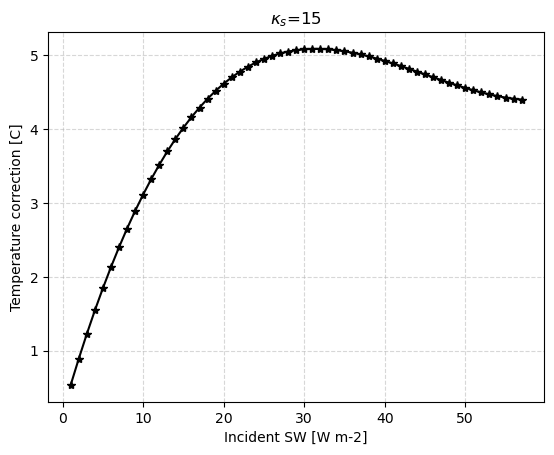

In [101]:
generic_xs = np.arange(0,80)
# corrected_ys = coeffs[0]*generic_xs**3 + coeffs[1]*generic_xs**2 + coeffs[2]*generic_xs**1 + coeffs[3]
# corrected_ys = coeffs[0]*generic_xs**3 + coeffs[1]*generic_xs**2 + coeffs[2]*generic_xs**1 + coeffs[3]
# corrected_ys = func(generic_xs, *popt) ## log fit

corrected_ys = spline(generic_xs)
plt.plot(generic_xs, corrected_ys, c='k', marker='*')

plt.grid(alpha=.5, ls='--')
plt.xlabel('Incident SW [W m-2]')
plt.ylabel('Temperature correction [C]')
plt.title('$\kappa_s$={:.0f}'.format(ks_vis))
plt.show()

Apply correction: need to get SW absorbed to be same array shape/references to surface as temperature...!

In [102]:
# make simba heights/depths relative to surface
depths_rel_to_sfc = np.repeat(simba_heights[np.newaxis,:], simba_dates.shape[0], axis=0)
sfc_height_2d = np.repeat(simba_sfc[:,np.newaxis], simba_heights.shape[0], axis=1)
# print(depths_rel_to_sfc[1000,:])
# print()
# print(sfc_height_2d[1000,:])

depths_rel_to_sfc = depths_rel_to_sfc+ abs(sfc_height_2d)
depths_rel_to_sfc = np.ma.masked_greater(depths_rel_to_sfc, -2)/100.
# print()
# print(depths_rel_to_sfc[1000,:])
# print(season_data['temperature'].shape, depths_rel_to_sfc.shape, sfc_height_2d.shape)

In [239]:
## using SWN array from above
ks_vis = 2.
simba_swn_2d = np.repeat(simba_swn[:,np.newaxis], depths_rel_to_sfc.shape[1], axis=1)
simba_swa, _ = calc_sw_ext(simba_swn_2d, ks_vis, depths_rel_to_sfc, f_nir=.5)
simba_swa = np.ma.masked_array(simba_swa, mask=depths_rel_to_sfc.mask)


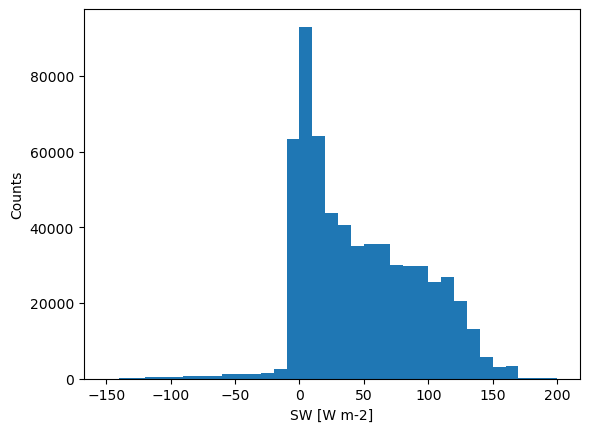

In [240]:
plt.hist(simba_swn_2d[~depths_rel_to_sfc.mask], bins=np.arange(-150,201,10))
plt.ylabel('Counts')
plt.xlabel('SW [W m-2]')
plt.show()

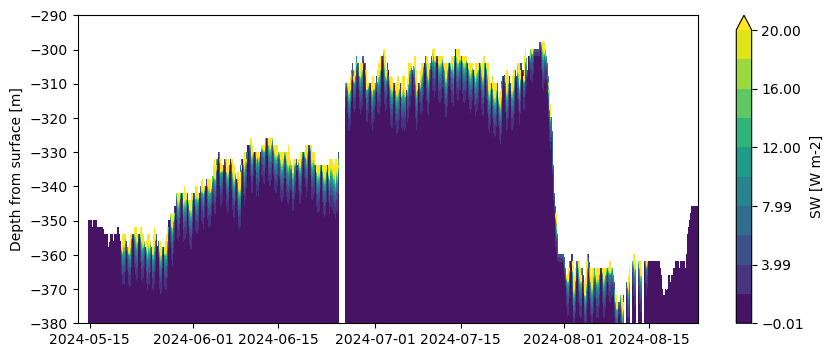

In [241]:
fig, ax = plt.subplots(1, figsize=(10,4))
cb = plt.contourf(simba_dates, simba_heights, np.swapaxes(simba_swa,0,1), levels=np.linspace(-.01,20,11), extend='max')
plt.colorbar(cb, label='SW [W m-2]')
plt.ylabel('Depth from surface [m]')
plt.ylim(-380,-290)
plt.show()

#### temperature corrections

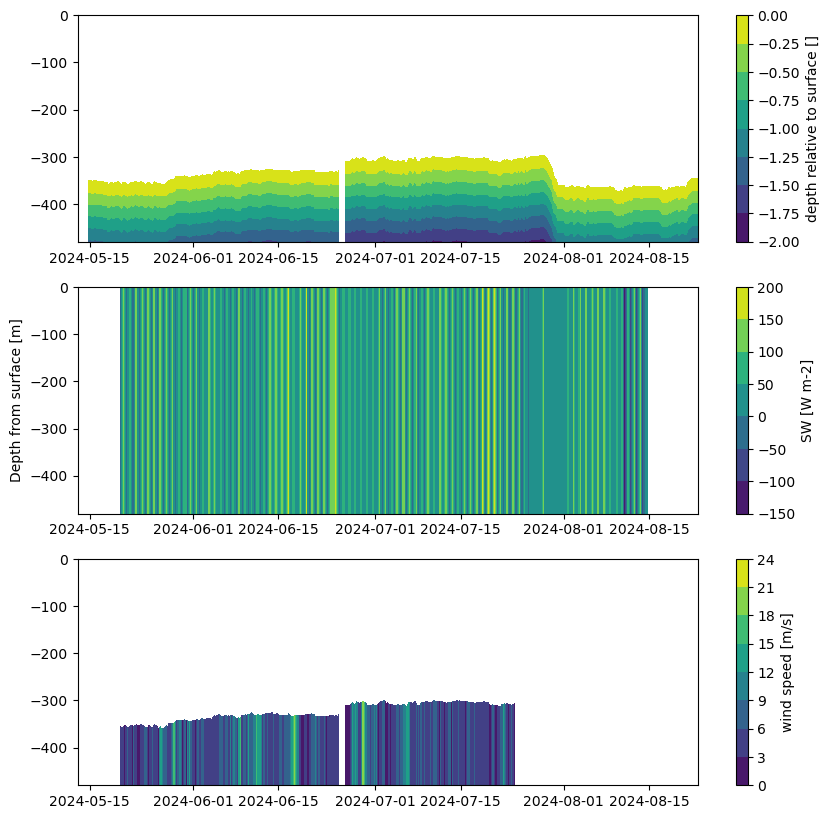

In [242]:
fig, axs = plt.subplots(3, figsize=(10,10))
cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(depths_rel_to_sfc,0,1))#, levels=np.linspace(0,20,11), extend='max')
plt.colorbar(cb, label='depth relative to surface []', ax=axs[0])

cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(simba_swn_2d,0,1))#, levels=np.linspace(0,20,11), extend='max')
plt.colorbar(cb, label='SW [W m-2]', ax=axs[1])

cb = axs[2].contourf(simba_dates, simba_heights, np.swapaxes(wspd_2d_full,0,1))#, levels=np.linspace(0,20,11), extend='max')
plt.colorbar(cb, label='wind speed [m/s]', ax=axs[2])


axs[1].set_ylabel('Depth from surface [m]')
# plt.ylim(-.15,0)
plt.show()

## OLD: calculate temperature correction and subtract from temperatures from various "best fit" lines

# temp_correction = coeffs[0]*simba_swa**3 + coeffs[1]*simba_swa**2 + coeffs[2]*simba_swa**1 + coeffs[3]
temp_correction = func(simba_swa, *popt)
temp_correction[np.where(temp_correction<0)] = 0

In [243]:
## write a new function that uses wind information to correct temperature
## should input of function include dictionary with splines???
## uchange key to include ranges?

def cal_temp_correct_ws(sw_in, ws_in):
    # wind_based_corrections has keys that are maximum winds: 5,10,25 (what is actual maximum wind speed in the data?)

    ## calculate temperature bias for all wind intervals
    corrections = {}
    for w in wind_based_corrections:
        w_spline = interpolate.BSpline(wind_based_corrections[w][0], wind_based_corrections[w][1], wind_based_corrections[w][2],)# extrapolate=False)
        w_correction = w_spline(sw_in)
        corrections[w] = w_correction

    # mid_correction = wind_based_corrections[10](sw_in)
    # hi_correction = wind_based_corrections[25](sw_in)

    ## only use corrections for each wind interval
    temp_correction_out = np.zeros(sw_in.shape)
    temp_correction_out[np.where(ws_in<5)] = corrections[5][np.where(ws_in<5)]
    temp_correction_out[np.where((ws_in>=5)&(ws_in<10))] = corrections[10][np.where((ws_in>=5)&(ws_in<10))]
    temp_correction_out[np.where(ws_in>=10)] = corrections[25][np.where(ws_in>=10)]

    return temp_correction_out

In [203]:
## need wind speed with same shape as sw
wspd_2d_full = np.repeat(simba_wspd[:,np.newaxis], simba_swa.shape[1], axis=1)
wspd_2d_full = np.ma.masked_array(wspd_2d_full, mask=simba_swa.mask)

In [166]:
print(wspd_2d_full.shape, simba_swa.shape)

(9504, 241) (9504, 241)


In [244]:
## need to check function is doing what you think...
ws_temp_correction = cal_temp_correct_ws(simba_swa, wspd_2d_full)
ws_temp_correction = np.ma.masked_array(ws_temp_correction, mask=simba_swa.mask)

## for adding you want 0 if there's no correction

NOTE: still have issue of how to force (?) correction to be 0 at 0 since it isn't true at low wind speeds.....

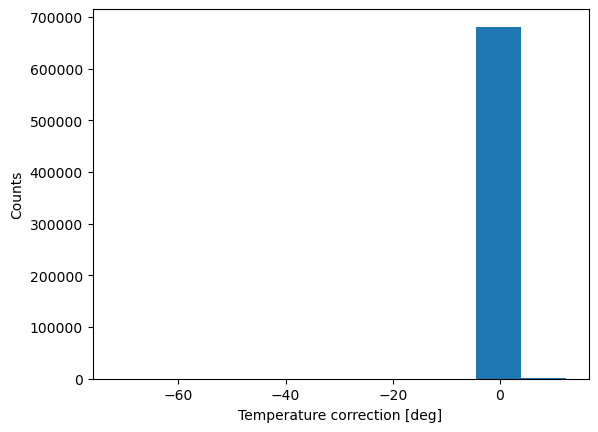

In [211]:
plt.hist(ws_temp_correction[~ws_temp_correction.mask].flatten(),)# bins=np.arange(-7,7,.5))
plt.xlabel('Temperature correction [deg]')
plt.ylabel('Counts')
plt.show()

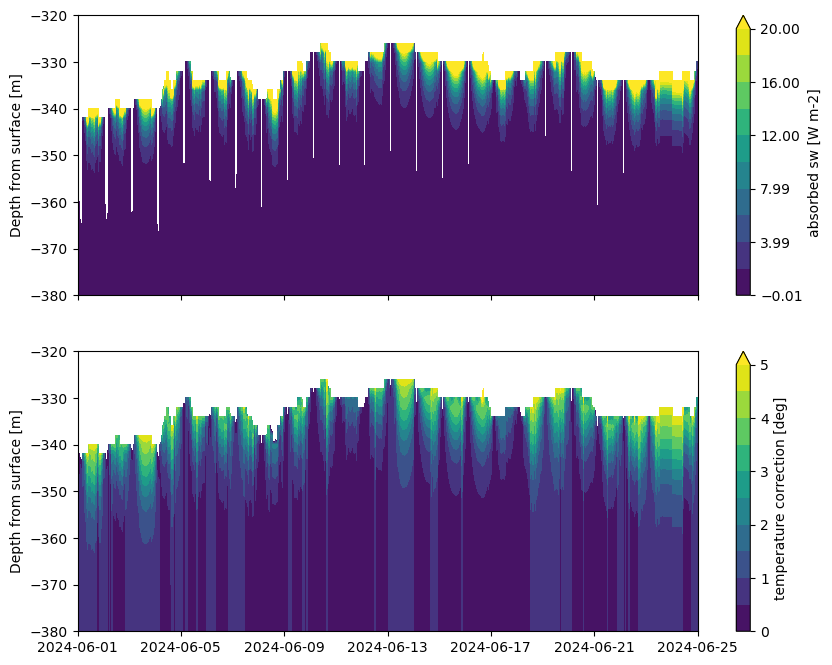

In [245]:
fig, axs = plt.subplots(2, figsize=(10,8), sharex=True, sharey=True)
cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(simba_swa,0,1), levels=np.linspace(-.01,20,11), extend='max')
plt.colorbar(cb, label='absorbed sw [W m-2]', ax=axs[0])
axs[0].set_ylabel('Depth from surface [m]')

cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(ws_temp_correction,0,1), levels=np.arange(0,5.01,.5), extend='max')
plt.colorbar(cb, label='temperature correction [deg]', ax=axs[1])
axs[1].set_ylabel('Depth from surface [m]')

axs[0].set_ylim(-380,-320)
axs[0].set_xlim(dt(2024,6,1),dt(2024,6,25))
plt.show()

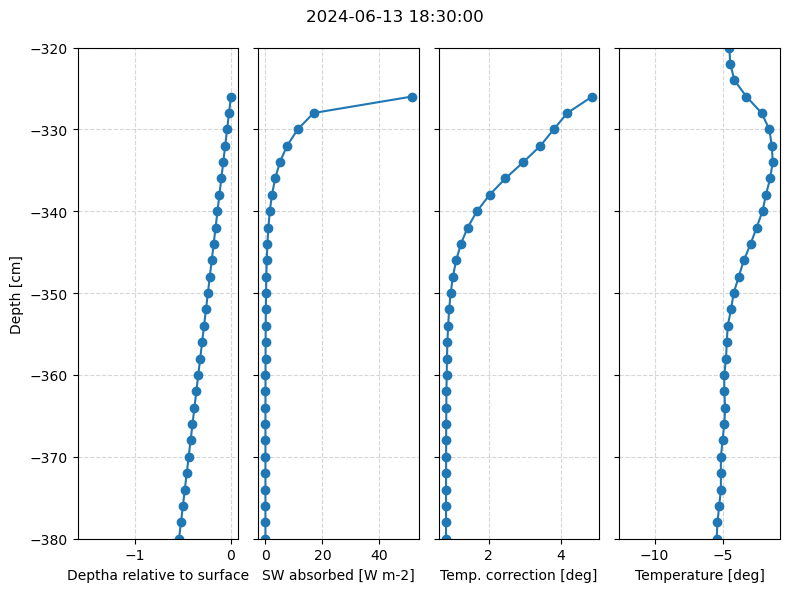

In [246]:
fig, axs = plt.subplots(1,4, figsize=(8,6), sharey=True)

idx = 3050

xlabels = ['Deptha relative to surface', 'SW absorbed [W m-2]', 'Temp. correction [deg]', 'Temperature [deg]']

for i, (ax, var) in enumerate(zip(axs.ravel(), [depths_rel_to_sfc, simba_swa, ws_temp_correction, season_data['temperature']])):
    ax.plot(var[idx,:-1], simba_heights[:-1], marker='o')
    ax.set_xlabel(xlabels[i])
    ax.grid(alpha=.5, ls='--')
axs[0].set_ylim(-380,-320)
axs[0].set_ylabel('Depth [cm]')
plt.suptitle(simba_dates[idx])
plt.tight_layout()

In [247]:
# temp_correction[depths_rel_to_sfc.mask] = 0.
corrected_temps = season_data['temperature'] - ws_temp_correction

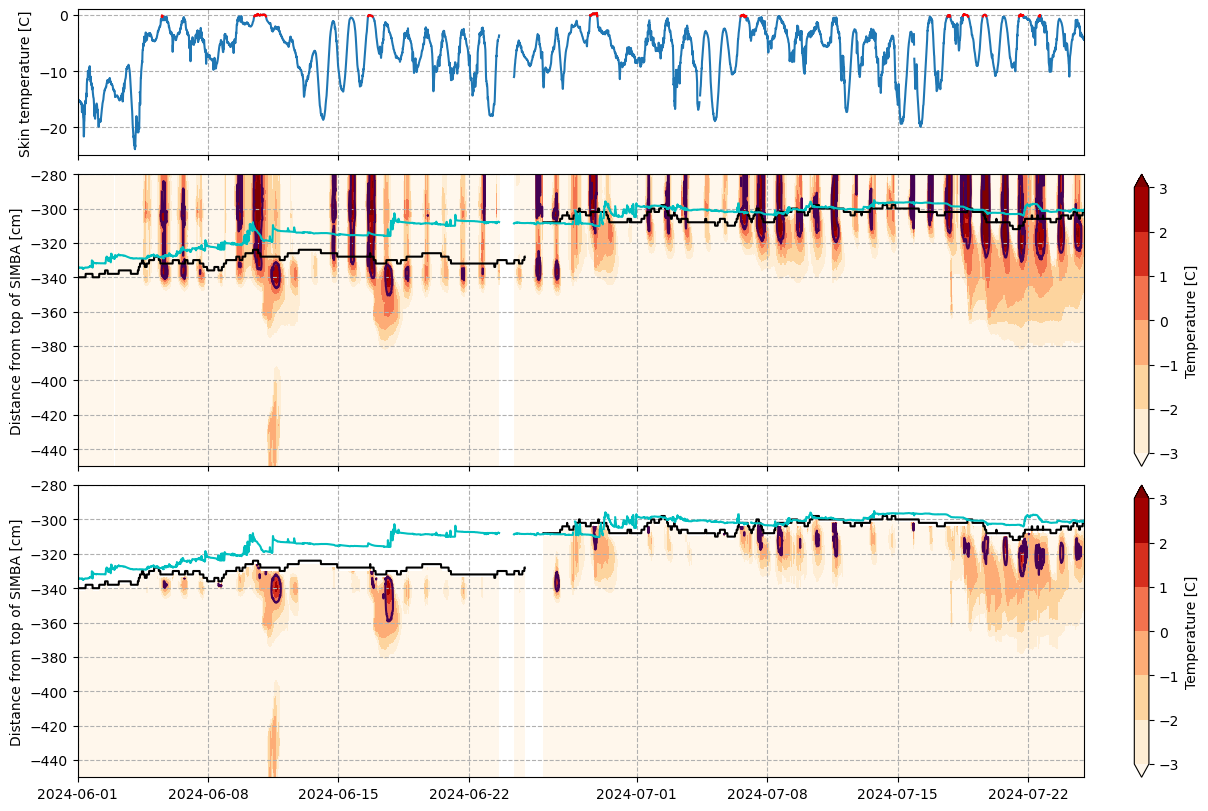

In [248]:
fig, axs = plt.subplots(3, figsize=(12,8), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]))

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')
axs[0].set_ylabel('Skin temperature [C]')

cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(season_data['temperature'],0,1),
                cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
axs[1].contour(simba_dates, season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                levels=[1], extend='both')
plt.colorbar(cb, ax=axs[1], label='Temperature [C]')

cb = axs[2].contourf(simba_dates, simba_heights, np.swapaxes(corrected_temps,0,1),
                cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
axs[2].contour(simba_dates, season_data['height'], np.swapaxes(corrected_temps,0,1),
                levels=[0], extend='both')
plt.colorbar(cb, ax=axs[2], label='Temperature [C]')

for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')
    if i>0:
        ax.plot(simba_dates, simba_sfc, c='k')
        ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth']-350, c='c')
        ax.set_ylabel('Distance from top of SIMBA [cm]')
        ax.set_ylim(-450, -280)

axs[0].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,25))
axs[0].set_ylim(-25,1)



# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)

plt.show()

#### Digression for Michael

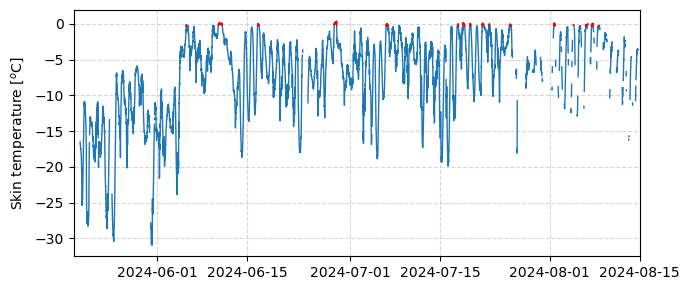

In [187]:
## quick plot for Michael
fig, ax = plt.subplots(1, figsize=(7,3), )#constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]))

ax.plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15, lw=1)
ax.plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r', lw=1)
ax.set_ylabel('Skin temperature [$^o$C]')

ax.grid(ls='--', alpha=.5)
ax.set_xlim(dt(2024,5,19),dt(2024,8,15))
plt.tight_layout()
# plt.savefig('/home/asledd/ICECAPS/Raven_skinT_melt-highlight_20240519-20240815.png', dpi=200)
plt.show()

In [188]:
masked_tskin = np.ma.masked_less(sleigh_tskin_all-273.15, -0.3)
melt_dates = asfs_data_lev2['dates'][~masked_tskin.mask]
print(melt_dates)

[datetime.datetime(2024, 6, 5, 12, 30)
 datetime.datetime(2024, 6, 5, 12, 40)
 datetime.datetime(2024, 6, 5, 13, 20)
 datetime.datetime(2024, 6, 5, 13, 30)
 datetime.datetime(2024, 6, 5, 18, 20)
 datetime.datetime(2024, 6, 9, 15, 40)
 datetime.datetime(2024, 6, 9, 16, 50)
 datetime.datetime(2024, 6, 9, 19, 0)
 datetime.datetime(2024, 6, 10, 11, 40)
 datetime.datetime(2024, 6, 10, 11, 50)
 datetime.datetime(2024, 6, 10, 12, 0)
 datetime.datetime(2024, 6, 10, 12, 10)
 datetime.datetime(2024, 6, 10, 12, 20)
 datetime.datetime(2024, 6, 10, 12, 30)
 datetime.datetime(2024, 6, 10, 12, 40)
 datetime.datetime(2024, 6, 10, 12, 50)
 datetime.datetime(2024, 6, 10, 13, 0)
 datetime.datetime(2024, 6, 10, 13, 10)
 datetime.datetime(2024, 6, 10, 13, 20)
 datetime.datetime(2024, 6, 10, 13, 30)
 datetime.datetime(2024, 6, 10, 13, 40)
 datetime.datetime(2024, 6, 10, 13, 50)
 datetime.datetime(2024, 6, 10, 14, 0)
 datetime.datetime(2024, 6, 10, 14, 10)
 datetime.datetime(2024, 6, 10, 14, 20)
 datetime.da

In [189]:
import csv

In [191]:
## write out melt times to CSV for michael

# with open("Raven_skinT_melt_times_20240519-20240815.csv","w") as csvFile:
#     Fileout = csv.writer(csvFile, delimiter=',',)# quoting=csv.QUOTE_ALL)
#     Fileout.writerow(melt_dates)

with open('Raven_skinT_melt_times_20240519-20240815.csv', 'w', ) as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    for item in melt_dates:
        wr.writerow([item])

### Back to looking at orrected temperatures: do they make sense?

(19875.0, 19929.0)

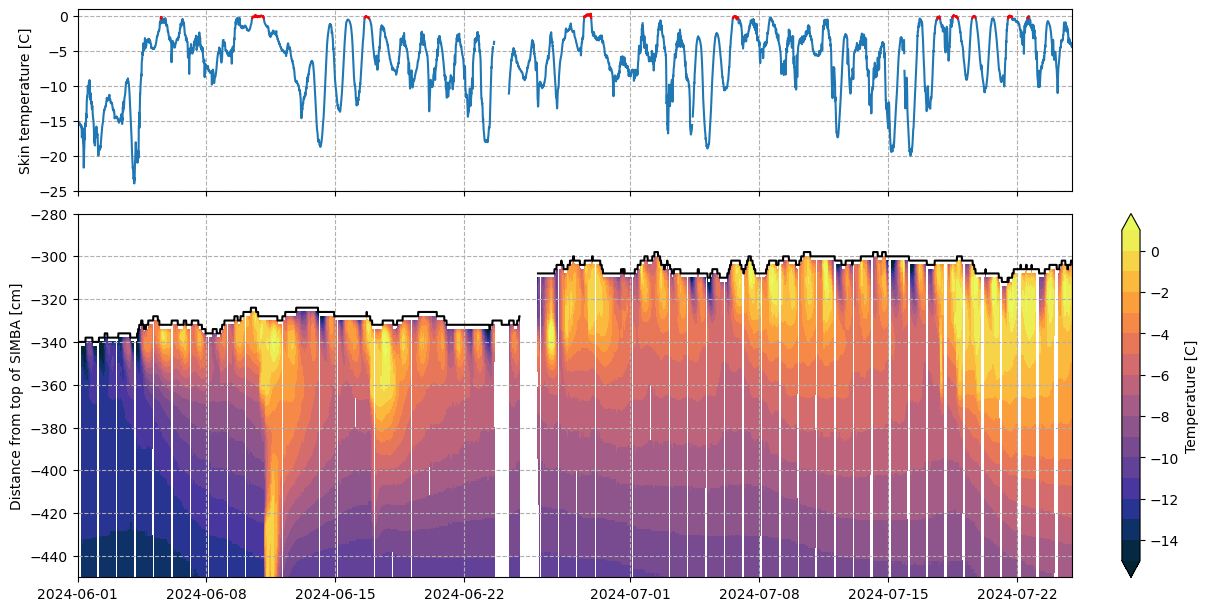

In [76]:
fig, axs = plt.subplots(2, figsize=(12,6), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,2,]))

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')
axs[0].set_ylabel('Skin temperature [C]')

cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(corrected_temps,0,1),
                cmap=cmocean.cm.thermal, levels=np.arange(-15,1.1,1), extend='both')
# axs[1].contour(simba_dates, season_data['height'], np.swapaxes(corrected_temps,0,1),
#                 levels=[0], extend='both', lw=1)
plt.colorbar(cb, ax=axs[1], label='Temperature [C]')

for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')
    if i>0:
        ax.plot(simba_dates, simba_sfc, c='k')
        ax.set_ylabel('Distance from top of SIMBA [cm]')
        ax.set_ylim(-450, -280)
axs[0].set_ylim(-25,1)
axs[0].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,25))

96
96
96
96
96


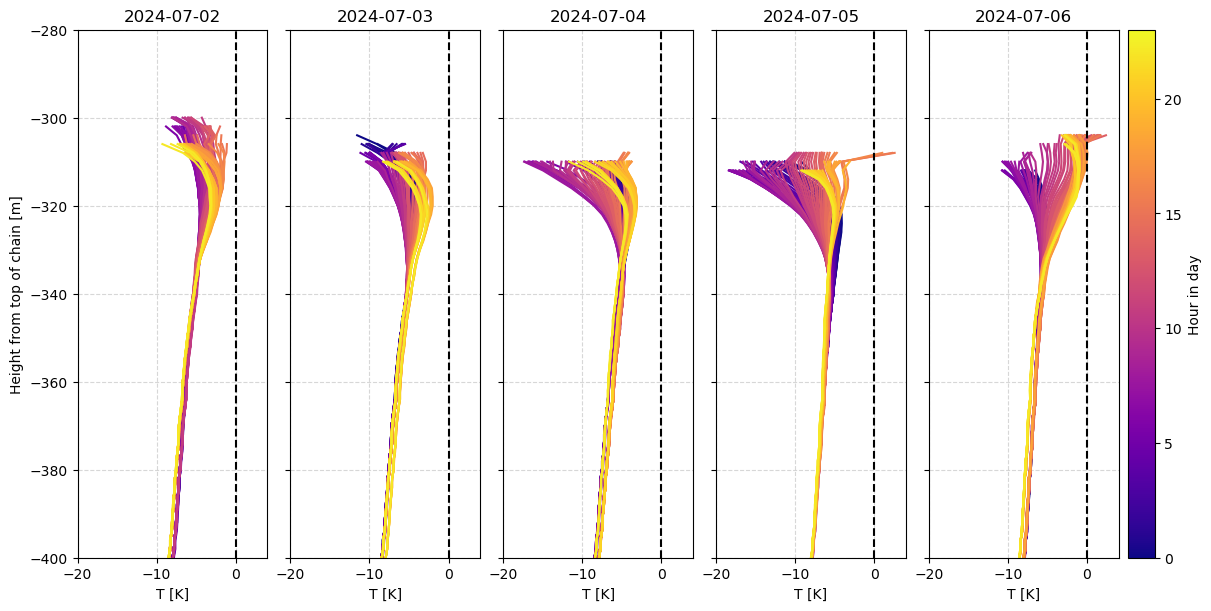

96
96
96
96
96


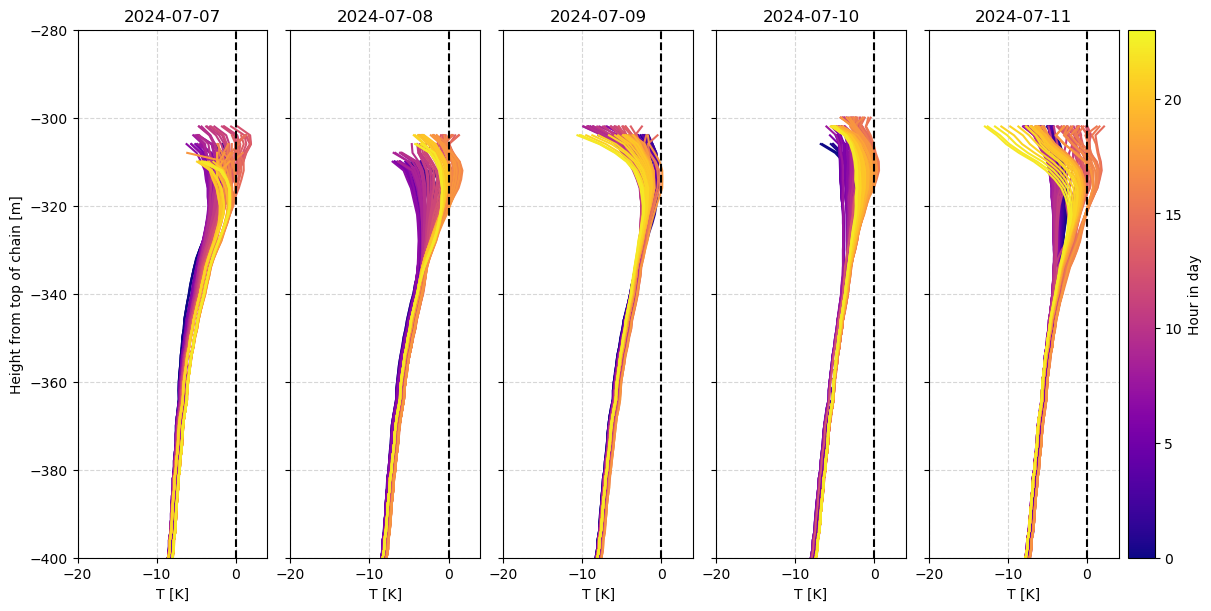

96
96
96
96
96


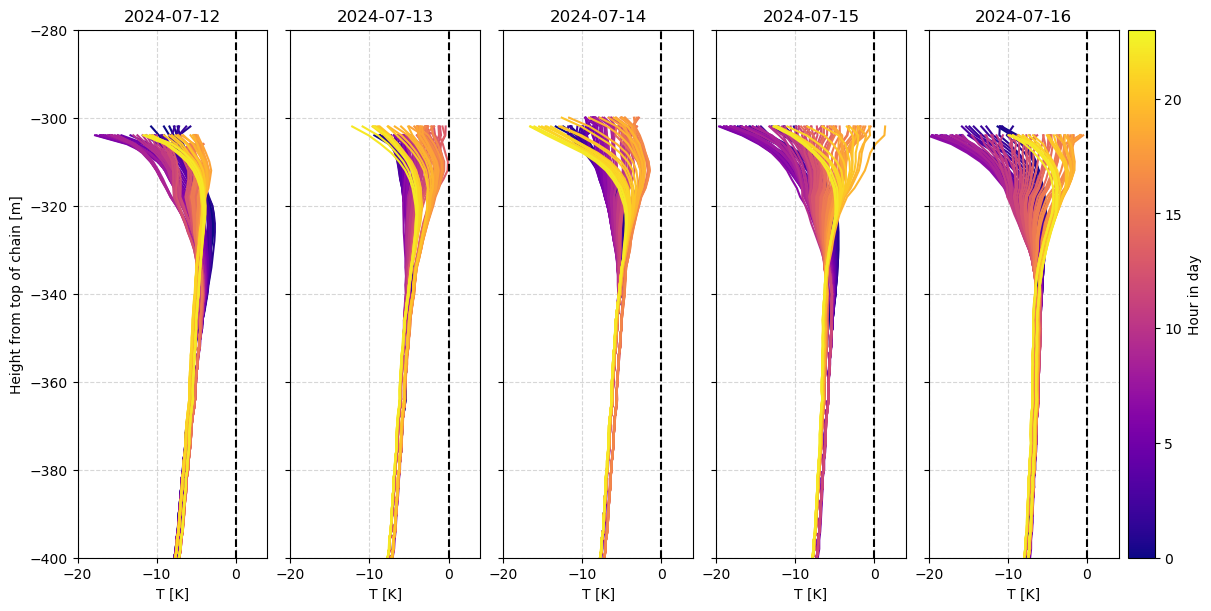

96
96
96
96
96


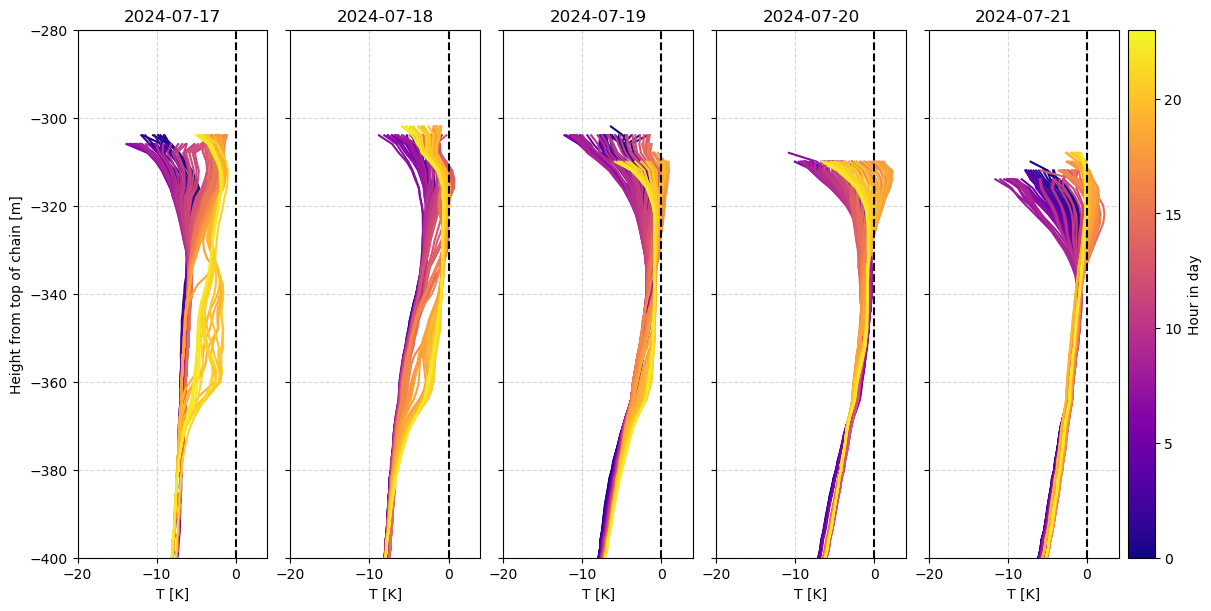

96
96
96
96
96


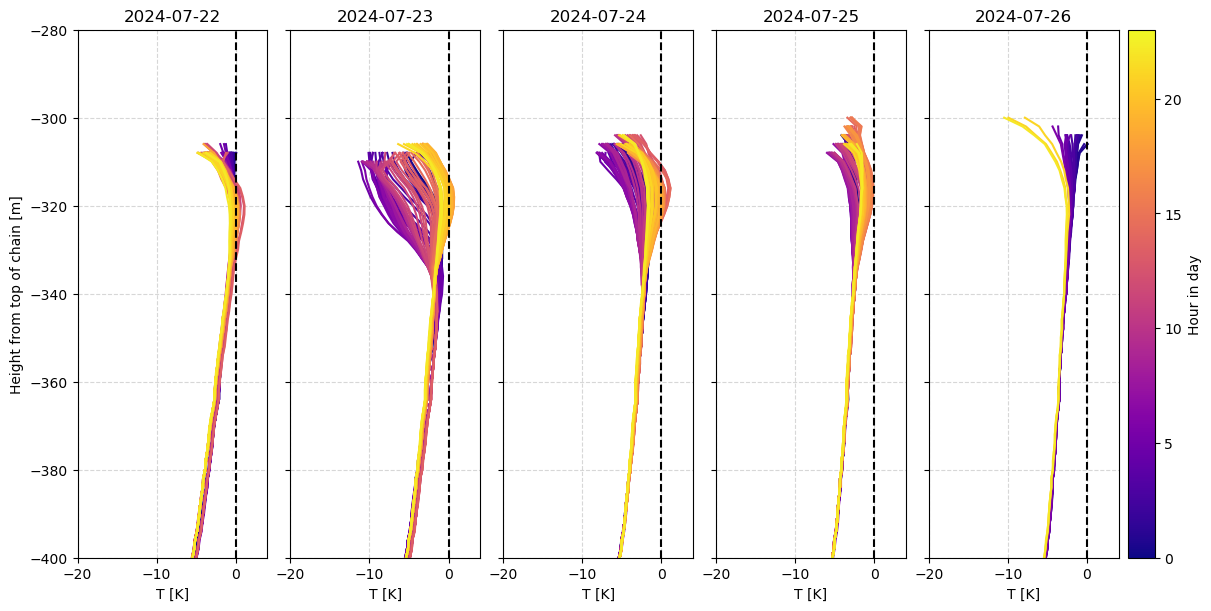

In [249]:
# Look at profiles?

## for june
# for day in range(1,31,5):

## for july
for day in range(1,26,5):
    fig, axs = plt.subplots(1,5, figsize=(12,6), sharey=True, sharex=True, constrained_layout=True)
    axs[0].set_ylabel('Height from top of chain [m]')
    
    # day = 9
    for ad, ax in zip(range(5), axs.ravel()):
        st_date = datetime.datetime(2024,7,1)+datetime.timedelta(days=day+ad)
        en_date = st_date+datetime.timedelta(days=1)
        figure_date_idx = np.where((np.asarray(simba_dates)>=st_date )&(np.asarray(simba_dates)<en_date ))[0]
        # print(len(figure_date_idx))
        # cbar_ticks = [plt_times[figure_date_idx[idx]] for idx in [0, int(len(figure_date_idx)/2), len(figure_date_idx)-1]]
        cbar_ticks = [0, 12, 23]
        
        for i, t_idx in np.ndenumerate(figure_date_idx[1:]):#[::-1]):
            
            col = plt.cm.plasma(simba_dates[t_idx].hour/24.)
            # print(corrected_temps[t_idx, :])
            ax.plot(np.squeeze(corrected_temps[t_idx, :-1]), simba_heights[:-1], label=t_idx, c=col)#'t=0')
    
        ax.set_xlabel('T [K]')
        ax.grid(alpha=.5, ls='--')
        ax.set_title(st_date.strftime('%Y-%m-%d'))
        ax.axvline(x=0., c='k', ls='--')
        ax.set_xlim(-20, 4)
    axs[0].set_ylim(-400,-280)
    cmappable = ScalarMappable(norm=Normalize(0,23), cmap=plt.cm.plasma)
    
    #colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
    cbar = plt.colorbar(cmappable, label='Hour in day')# ticks=np.arange(0, 23))#
    # cbar.ax.set_yticklabels(cbar_ticks)
    
    # axs[-1].set_xlim(-.1,2)
    # axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'--'+en_date.strftime('%m-%d %H:%M'))
    daystring_st = datetime.datetime(2024,7,day)
    daystring_en = datetime.datetime(2024,7,day+4)
    filename = 'Raven_temp-height_reverse_'+daystring_st.strftime('%Y%m%d-')+daystring_en.strftime('%Y%m%d')+'.png'
    # plt.savefig('/home/asledd/ICECAPS/temperature_profiles/'+filename, dpi=250)
    plt.show()

### Want to see if wind speed has an impact, ie low wind speeds coincide with larger biases a la Mike Town

Need wind speeds from Michael (from PROMICE)

In [76]:
# varnames = ['wspd_l']

### Old figures...

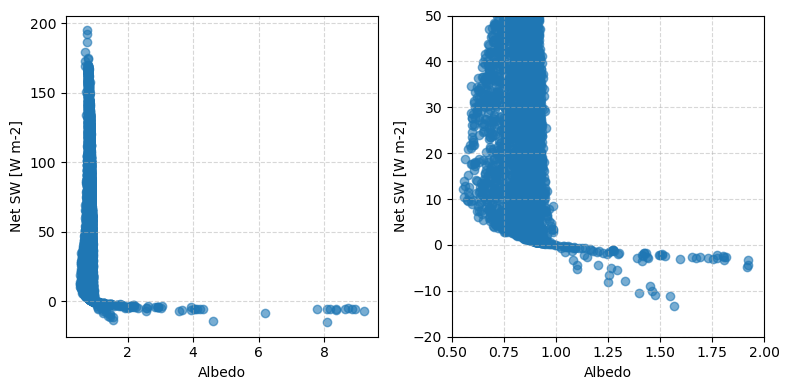

In [77]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
for ax in axs.ravel():
    ax.scatter(asfs_data_lev2['albedo'], asfs_data_lev2['net_short_hemisp'], alpha=.6)
    ax.grid(alpha=.5, ls='--')
    ax.set_ylabel('Net SW [W m-2]')
    ax.set_xlabel('Albedo')

axs[1].set_xlim(.5,2)
axs[1].set_ylim(-20,50)

plt.tight_layout()
plt.show()

Try to get a handle on location/occurance of temperatures>0C

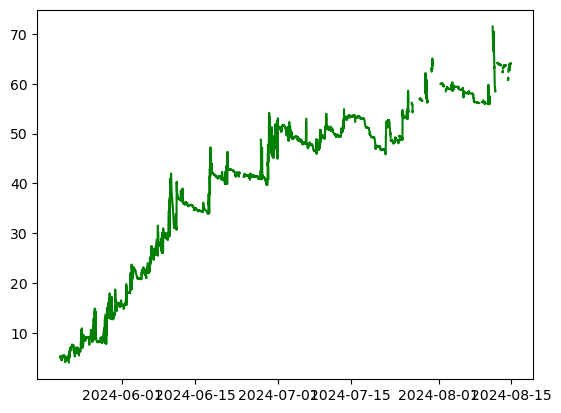

In [78]:
plt.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], c='g')
plt.show()

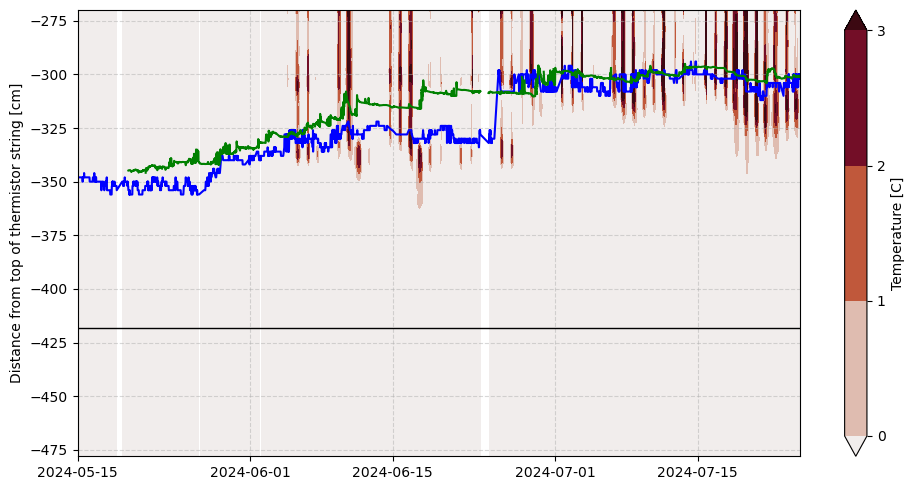

In [79]:
fig, ax = plt.subplots(1, figsize=(10,5))

## figure out pythonic looping later
cb = ax.contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=cmocean.cm.amp, levels=np.arange(0,4,1), extend='both')
plt.colorbar(cb, ax=ax, label='Temperature [C]')

ax.plot(season_data['dates'], simba_sfc_heights, c='b')
ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth']-350, c='g')

ax.set_ylim(-478, -270)
ax.set_xlim(dt(2024,5,15), dt(2024,7,25))
ax.set_ylabel('Distance from top of thermistor string [cm]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=-209*2, c='k', lw=1) ## top of ice chunk discovered at demob


plt.tight_layout()
plt.show()

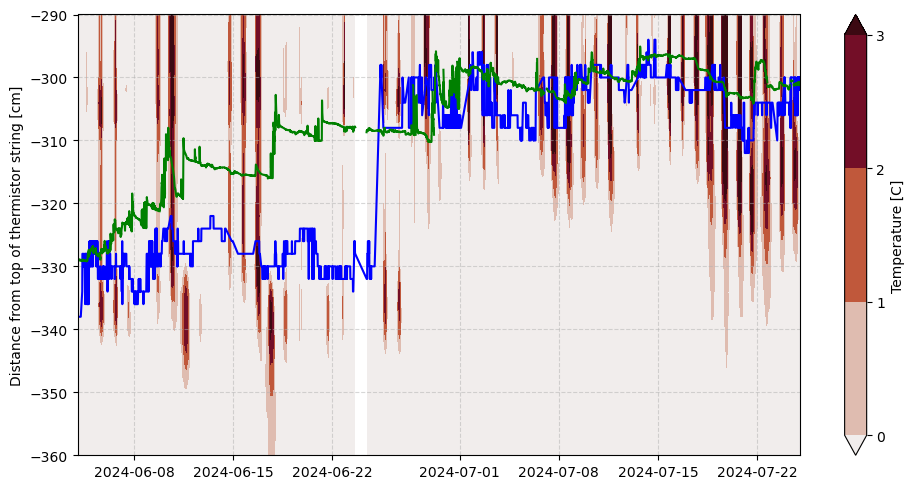

In [80]:
fig, ax = plt.subplots(1, figsize=(10,5))

## figure out pythonic looping later
cb = ax.contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=cmocean.cm.amp, levels=np.arange(0,4,1), extend='both')
plt.colorbar(cb, ax=ax, label='Temperature [C]')

ax.plot(season_data['dates'], simba_sfc_heights, c='b')
ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth']-350, c='g')

ax.set_ylim(-360, -290)
ax.set_xlim(dt(2024,6,4), dt(2024,7,25))
ax.set_ylabel('Distance from top of thermistor string [cm]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=-209*2, c='k', lw=1) ## top of ice chunk discovered at demob


plt.tight_layout()
plt.show()

/tmp/ipykernel_2049079/211313052.py:7: UserWarning: The following kwargs were not used by contour: 'lw'
  cb = ax.contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),


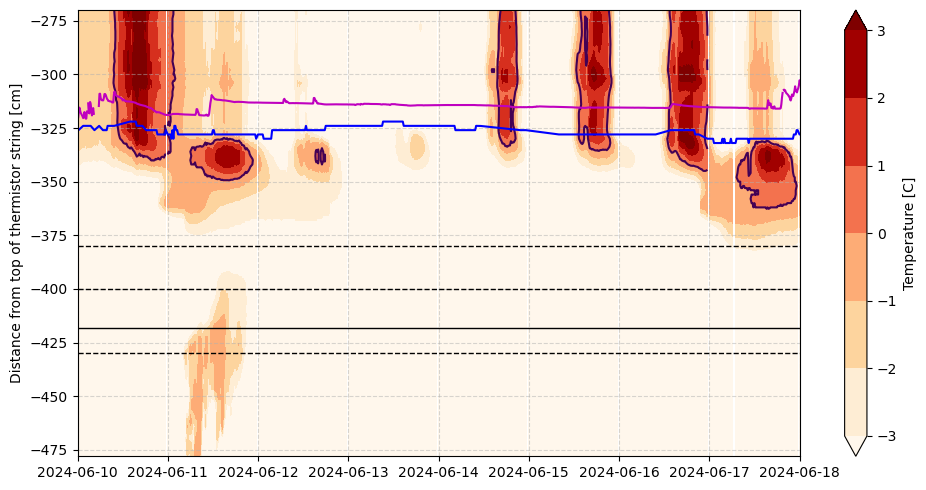

In [81]:
fig, ax = plt.subplots(1, figsize=(10,5))

## figure out pythonic looping later
cb = ax.contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
plt.colorbar(cb, ax=ax, label='Temperature [C]')
cb = ax.contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                levels=[0], extend='both', lw=1)

ax.plot(season_data['dates'], simba_sfc_heights, c='b')
ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth']-350, c='m')

ax.set_ylim(-478, -270)
ax.set_xlim(dt(2024,5,15), dt(2024,7,25))
ax.set_ylabel('Distance from top of thermistor string [cm]')
ax.grid(alpha=.5, ls='--')
ax.axhline(y=-209*2, c='k', lw=1) ## top of ice chunk discovered at demob


for therm in [190, 200, 215]:
    ax.axhline(y=-therm*2, c='k', lw=1, ls='--')

# ax.set_ylim(-360, -270)
ax.set_xlim(dt(2024,6,10), dt(2024,6,18))

plt.tight_layout()
plt.show()